In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm as tqdm
from sklearn.manifold import TSNE
import torch
import torchvision  # for dataset
import torch.nn as nn   # for neural networks
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data import random_split
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.optim as optim

import time
from tqdm import tqdm

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# Define transform to normalize data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])

# Load train and test sets
train_set = datasets.STL10(root='./data', split='train', download=True, transform=transform)
test_set = datasets.STL10(root='./data', split='test', download=True, transform=transform)


  0%|          | 0/2640397119 [00:00<?, ?it/s]

Extracting ./data/stl10_binary.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)

In [ ]:
from torchvision.models import resnet18

# Define ResNet-18 architecture
resnet = resnet18(pretrained=True)
resnet.fc = nn.Linear(512, 10)
resnet = resnet.to(device)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
import copy

model = resnet
resnet_adam = copy.deepcopy(model)
resnet_adagrad = copy.deepcopy(model)
resnet_rms = copy.deepcopy(model)


In [ ]:
def train(model, device, train_loader, optimizer, epoch, reg_strength=0.001):
    model.train()
    train_loss = 0
    train_correct_top1 = 0
    train_correct_top5 = 0
    num_batches = len(train_loader)
    with tqdm(total=num_batches, desc=f'Training Epoch {epoch}', unit='batch') as pbar:
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = F.cross_entropy(output, target)

            # L2 regularization
            reg_loss = sum(param.norm(2) ** 2 for param in model.parameters())
            loss += reg_strength * reg_loss

            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            # Calculate top-1 and top-5 accuracy
            _, predicted = torch.topk(output, k=5, dim=1)
            train_correct_top1 += torch.sum(predicted[:, 0] == target)
            train_correct_top5 += torch.sum(predicted == target.unsqueeze(1))

            # Update progress bar
            pbar.set_postfix({'loss': train_loss / (batch_idx + 1)})
            pbar.update()

    train_loss /= len(train_loader.dataset)
    train_acc_top1 = train_correct_top1.double() / len(train_loader.dataset)
    train_acc_top5 = train_correct_top5.double() / len(train_loader.dataset)
    return train_loss, train_acc_top1, train_acc_top5


In [ ]:
def test(model, device, test_loader, reg_strength=0.001):
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    test_correct_top5 = 0
    num_batches = len(test_loader)
    with tqdm(total=num_batches, desc='Testing', unit='batch') as pbar:
        with torch.no_grad():
            for batch_idx, (data, target) in enumerate(test_loader):
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = F.cross_entropy(output, target, reduction='sum')

                # L2 regularization
                reg_loss = sum(param.norm(2) ** 2 for param in model.parameters())
                loss += reg_strength * reg_loss

                test_loss += loss.item()
                _, predicted = torch.max(output.data, 1)
                test_total += target.size(0)
                test_correct += (predicted == target).sum().item()

                # Top-5 accuracy
                _, top5_predicted = torch.topk(output.data, 5, dim=1)
                for i in range(len(target)):
                    if target[i] in top5_predicted[i]:
                        test_correct_top5 += 1

                # Update progress bar
                pbar.set_postfix({'loss': test_loss / (batch_idx + 1)})
                pbar.update()

    test_loss /= len(test_loader.dataset)
    test_acc = test_correct / test_total
    test_acc_top5 = test_correct_top5 / test_total
    return test_loss, test_acc, test_acc_top5


## Trying diffrent optimizers

### using Adam optimizer with defualt values and lr = 3e-4

In [ ]:
torch.manual_seed(42)
# Hyperparameters
batch_size = 256
learning_rate = 3e-5  # try 4e-5, 5e-4
num_epochs = 10
# Initialize model and optimizer
model = resnet_adam
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
test_losses_adam_def = []
test_accuracies_top1_adam_def = []
test_accuracies_top5_adam_def = []
train_losses_adam_def = []
train_accuracies_top1_adam_def = []
train_accuracied_top5_adam_def = []

# Train and test the model
for epoch in range(num_epochs):
    train_loss, train_acc_top1, train_acc_top5 = train(model, device, train_loader, optimizer, epoch, 0.001)
    test_loss, test_acc_top1, test_acc_top5 = test(model, device, test_loader, 0.001)
    train_losses_adam_def.append(train_loss)
    train_accuracies_top1_adam_def.append(train_acc_top1)
    train_accuracied_top5_adam_def.append(train_acc_top5)
    test_losses_adam_def.append(test_loss)
    test_accuracies_top1_adam_def.append(test_acc_top1)
    test_accuracies_top5_adam_def.append(test_acc_top5)
    print()
    print("Epoch: ", epoch + 1, "Train Loss: ", train_loss, "Train Acc top 1: ", train_acc_top1.item(), "Test Loss: ", test_loss, "Test Acc top 1: ", test_acc_top1)
    print("Train Acc top 5: ", train_acc_top5.item(), "Test Acc top 5: ", test_acc_top5)
    print()

train_losses_adam_def = torch.tensor(train_losses_adam_def)
train_accuracies_top1_adam_def = torch.tensor(train_accuracies_top1_adam_def)
train_accuracied_top5_adam_def = torch.tensor(train_accuracied_top5_adam_def)
test_losses_adam_def = torch.tensor(test_losses_adam_def)
test_accuracies_top1_adam_def = torch.tensor(test_accuracies_top1_adam_def)
test_accuracies_top5_adam_def = torch.tensor(test_accuracies_top5_adam_def)

train_losses_adam_def = train_losses_adam_def.cpu().numpy()
train_accuracies_top1_adam_def = train_accuracies_top1_adam_def.cpu().numpy()
train_accuracied_top5_adam_def = train_accuracied_top5_adam_def.cpu().numpy()
test_losses_adam_def = test_losses_adam_def.cpu().numpy()
test_accuracies_top1_adam_def = test_accuracies_top1_adam_def.cpu().numpy()
test_accuracies_top5_adam_def = test_accuracies_top5_adam_def.cpu().numpy()


Testing: 100%|██████████| 32/32 [00:06<00:00,  4.58batch/s, loss=324]



Epoch:  1 Train Loss:  0.03660593242645264 Train Acc top 1:  0.34640000000000004 Test Loss:  1.2960891876220704 Test Acc top 1:  0.612625
Train Acc top 5:  0.7964 Test Acc top 5:  0.945875



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.50batch/s, loss=215]



Epoch:  2 Train Loss:  0.032766534328460696 Train Acc top 1:  0.7382000000000001 Test Loss:  0.8610156569480896 Test Acc top 1:  0.7575
Train Acc top 5:  0.9686 Test Acc top 5:  0.976



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.54batch/s, loss=172]



Epoch:  3 Train Loss:  0.031208785438537598 Train Acc top 1:  0.8522000000000001 Test Loss:  0.6878648962974548 Test Acc top 1:  0.808125
Train Acc top 5:  0.9928 Test Acc top 5:  0.9855



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.90batch/s, loss=147]



Epoch:  4 Train Loss:  0.030382536315917967 Train Acc top 1:  0.912 Test Loss:  0.5873378872871399 Test Acc top 1:  0.83125
Train Acc top 5:  0.997 Test Acc top 5:  0.989625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.97batch/s, loss=132]



Epoch:  5 Train Loss:  0.02983547887802124 Train Acc top 1:  0.9458000000000001 Test Loss:  0.5295367546081543 Test Acc top 1:  0.844125
Train Acc top 5:  0.9988 Test Acc top 5:  0.990625



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.11batch/s, loss=122]



Epoch:  6 Train Loss:  0.02944530963897705 Train Acc top 1:  0.9734 Test Loss:  0.48957741403579713 Test Acc top 1:  0.85425
Train Acc top 5:  0.9994000000000001 Test Acc top 5:  0.991125



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.06batch/s, loss=115]



Epoch:  7 Train Loss:  0.02914707546234131 Train Acc top 1:  0.9862000000000001 Test Loss:  0.46177184772491453 Test Acc top 1:  0.8605
Train Acc top 5:  0.9998 Test Acc top 5:  0.99225



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.98batch/s, loss=112]



Epoch:  8 Train Loss:  0.02890860195159912 Train Acc top 1:  0.9936 Test Loss:  0.44733532905578616 Test Acc top 1:  0.862375
Train Acc top 5:  1.0 Test Acc top 5:  0.993125



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.90batch/s, loss=109]



Epoch:  9 Train Loss:  0.028715813446044923 Train Acc top 1:  0.9964000000000001 Test Loss:  0.4343420419692993 Test Acc top 1:  0.867375
Train Acc top 5:  1.0 Test Acc top 5:  0.992875



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.75batch/s, loss=107]


Epoch:  10 Train Loss:  0.028547763919830323 Train Acc top 1:  0.9986 Test Loss:  0.42864181447029115 Test Acc top 1:  0.867875
Train Acc top 5:  1.0 Test Acc top 5:  0.992875



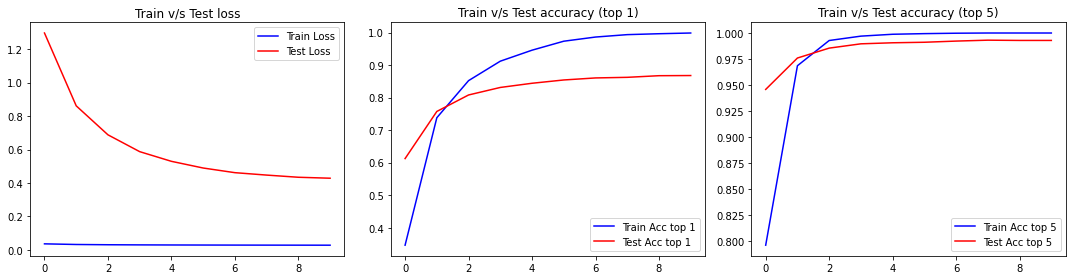

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plot train and test loss
axs[0].plot(train_losses_adam_def,'b-', label='Train Loss')
axs[0].plot(test_losses_adam_def,'r-', label='Test Loss')
axs[0].set_title('Train v/s Test loss')
axs[0].legend()

# Plot top 1 train and test accuracy
axs[1].plot(train_accuracies_top1_adam_def,'b-', label='Train Acc top 1')
axs[1].plot(test_accuracies_top1_adam_def,'r-', label='Test Acc top 1')
axs[1].set_title('Train v/s Test accuracy (top 1)')
axs[1].legend()

# Plot top 5 train and test accuracy
axs[2].plot(train_accuracied_top5_adam_def,'b-', label='Train Acc top 5')
axs[2].plot(test_accuracies_top5_adam_def,'r-', label='Test Acc top 5')
axs[2].set_title('Train v/s Test accuracy (top 5)')
axs[2].legend()

plt.tight_layout()
plt.show()


### using AdaGrad optimizer with defualt values and lr = 3e-4

In [ ]:
torch.manual_seed(42)
# Hyperparameters
batch_size = 256
learning_rate = 3e-5 # try 4e-5, 5e-4
num_epochs = 10
# Initialize model and optimizer
model = resnet_adagrad
optimizer = optim.Adagrad(model.parameters(), lr=learning_rate)

In [ ]:
test_losses_adagrad_def = []
test_accuracies_top1_adagrad_def = []
test_accuracies_top5_adagrad_def = []
train_losses_adagrad_def = []
train_accuracies_top1_adagrad_def = []
train_accuracied_top5_adagrad_def = []

# Train and test the model
for epoch in range(num_epochs):
    train_loss, train_acc_top1, train_acc_top5 = train(model, device, train_loader, optimizer, epoch, 0.001)
    test_loss, test_acc_top1, test_acc_top5 = test(model, device, test_loader, 0.001)
    train_losses_adagrad_def.append(train_loss)
    train_accuracies_top1_adagrad_def.append(train_acc_top1)
    train_accuracied_top5_adagrad_def.append(train_acc_top5)
    test_losses_adagrad_def.append(test_loss)
    test_accuracies_top1_adagrad_def.append(test_acc_top1)
    test_accuracies_top5_adagrad_def.append(test_acc_top5)
    print()
    print("Epoch: ", epoch + 1, "Train Loss: ", train_loss, "Train Acc top 1: ", train_acc_top1.item(), "Test Loss: ", test_loss, "Test Acc top 1: ", test_acc_top1)
    print("Train Acc top 5: ", train_acc_top5.item(), "Test Acc top 5: ", test_acc_top5)
    print()

train_losses_adagrad_def = torch.tensor(train_losses_adagrad_def)
train_accuracies_top1_adagrad_def = torch.tensor(train_accuracies_top1_adagrad_def)
train_accuracied_top5_adagrad_def = torch.tensor(train_accuracied_top5_adagrad_def)
test_losses_adagrad_def = torch.tensor(test_losses_adagrad_def)
test_accuracies_top1_adagrad_def = torch.tensor(test_accuracies_top1_adagrad_def)
test_accuracies_top5_adagrad_def = torch.tensor(test_accuracies_top5_adagrad_def)

train_losses_adagrad_def = train_losses_adagrad_def.cpu().numpy()
train_accuracies_top1_adagrad_def = train_accuracies_top1_adagrad_def.cpu().numpy()
train_accuracied_top5_adagrad_def = train_accuracied_top5_adagrad_def.cpu().numpy()
test_losses_adagrad_def = test_losses_adagrad_def.cpu().numpy()
test_accuracies_top1_adagrad_def = test_accuracies_top1_adagrad_def.cpu().numpy()
test_accuracies_top5_adagrad_def = test_accuracies_top5_adagrad_def.cpu().numpy()


Testing: 100%|██████████| 32/32 [00:07<00:00,  4.56batch/s, loss=499]



Epoch:  1 Train Loss:  0.03788764343261719 Train Acc top 1:  0.21400000000000002 Test Loss:  1.994990761756897 Test Acc top 1:  0.307625
Train Acc top 5:  0.6990000000000001 Test Acc top 5:  0.799



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.53batch/s, loss=449]



Epoch:  2 Train Loss:  0.03625733184814453 Train Acc top 1:  0.3808 Test Loss:  1.7968444585800172 Test Acc top 1:  0.41375
Train Acc top 5:  0.8420000000000001 Test Acc top 5:  0.8535



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.50batch/s, loss=415]



Epoch:  3 Train Loss:  0.03541047382354736 Train Acc top 1:  0.48800000000000004 Test Loss:  1.6582014255523683 Test Acc top 1:  0.475625
Train Acc top 5:  0.8916000000000001 Test Acc top 5:  0.8855



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.36batch/s, loss=388]



Epoch:  4 Train Loss:  0.03482697792053223 Train Acc top 1:  0.5644 Test Loss:  1.5500149965286254 Test Acc top 1:  0.525
Train Acc top 5:  0.9196000000000001 Test Acc top 5:  0.908125



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.43batch/s, loss=366]



Epoch:  5 Train Loss:  0.034386671829223635 Train Acc top 1:  0.5986 Test Loss:  1.464920383453369 Test Acc top 1:  0.557625
Train Acc top 5:  0.9364 Test Acc top 5:  0.919375



Testing: 100%|██████████| 32/32 [00:10<00:00,  3.11batch/s, loss=349]



Epoch:  6 Train Loss:  0.034012429428100587 Train Acc top 1:  0.6378 Test Loss:  1.3977918529510498 Test Acc top 1:  0.585875
Train Acc top 5:  0.9458000000000001 Test Acc top 5:  0.927



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.86batch/s, loss=332]



Epoch:  7 Train Loss:  0.03374247055053711 Train Acc top 1:  0.6632 Test Loss:  1.3291488857269287 Test Acc top 1:  0.612
Train Acc top 5:  0.9506 Test Acc top 5:  0.937



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.07batch/s, loss=319]



Epoch:  8 Train Loss:  0.03346276569366455 Train Acc top 1:  0.6930000000000001 Test Loss:  1.2770513086318969 Test Acc top 1:  0.633
Train Acc top 5:  0.9614 Test Acc top 5:  0.941125



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.74batch/s, loss=308]



Epoch:  9 Train Loss:  0.03324560146331787 Train Acc top 1:  0.7090000000000001 Test Loss:  1.2315364713668824 Test Acc top 1:  0.650125
Train Acc top 5:  0.9632000000000001 Test Acc top 5:  0.94575



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.68batch/s, loss=299]


Epoch:  10 Train Loss:  0.03304824047088623 Train Acc top 1:  0.7308 Test Loss:  1.194326789855957 Test Acc top 1:  0.664375
Train Acc top 5:  0.9660000000000001 Test Acc top 5:  0.94875



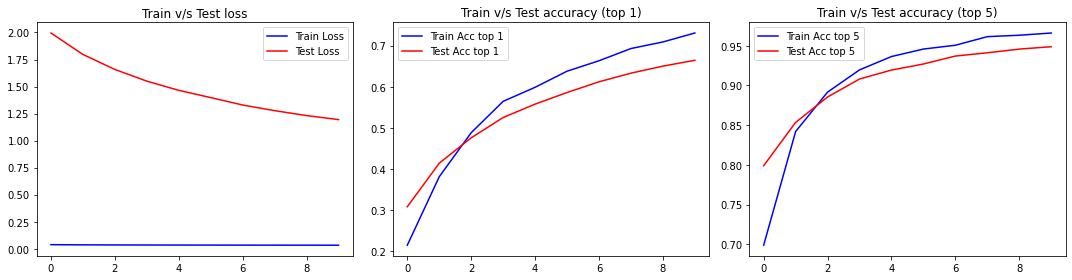

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plot train and test loss
axs[0].plot(train_losses_adagrad_def,'b-', label='Train Loss')
axs[0].plot(test_losses_adagrad_def,'r-', label='Test Loss')
axs[0].set_title('Train v/s Test loss')
axs[0].legend()

# Plot top 1 train and test accuracy
axs[1].plot(train_accuracies_top1_adagrad_def,'b-', label='Train Acc top 1')
axs[1].plot(test_accuracies_top1_adagrad_def,'r-', label='Test Acc top 1')
axs[1].set_title('Train v/s Test accuracy (top 1)')
axs[1].legend()

# Plot top 5 train and test accuracy
axs[2].plot(train_accuracied_top5_adagrad_def,'b-', label='Train Acc top 5')
axs[2].plot(test_accuracies_top5_adagrad_def,'r-', label='Test Acc top 5')
axs[2].set_title('Train v/s Test accuracy (top 5)')
axs[2].legend()

plt.tight_layout()
plt.show()


### using RMSprop optimizer with defualt values and lr = 3e-4

In [ ]:
torch.manual_seed(42)
# Hyperparameters
batch_size = 256
learning_rate = 3e-5  # try 4e-5, 5e-4
num_epochs = 10
# Initialize model and optimizer
model = resnet_rms
optimizer = optim.RMSprop(model.parameters(), lr=learning_rate)


In [ ]:
test_losses_rms_def = []
test_accuracies_top1_rms_def = []
test_accuracies_top5_rms_def = []
train_losses_rms_def = []
train_accuracies_top1_rms_def = []
train_accuracied_top5_rms_def = []

# Train and test the model
for epoch in range(num_epochs):
    train_loss, train_acc_top1, train_acc_top5 = train(model, device, train_loader, optimizer, epoch, 0.001)
    test_loss, test_acc_top1, test_acc_top5 = test(model, device, test_loader, 0.001)
    train_losses_rms_def.append(train_loss)
    train_accuracies_top1_rms_def.append(train_acc_top1)
    train_accuracied_top5_rms_def.append(train_acc_top5)
    test_losses_rms_def.append(test_loss)
    test_accuracies_top1_rms_def.append(test_acc_top1)
    test_accuracies_top5_rms_def.append(test_acc_top5)
    print()
    print("Epoch: ", epoch + 1, "Train Loss: ", train_loss, "Train Acc top 1: ", train_acc_top1.item(), "Test Loss: ", test_loss, "Test Acc top 1: ", test_acc_top1)
    print("Train Acc top 5: ", train_acc_top5.item(), "Test Acc top 5: ", test_acc_top5)
    print()

train_losses_rms_def = torch.tensor(train_losses_rms_def)
train_accuracies_top1_rms_def = torch.tensor(train_accuracies_top1_rms_def)
train_accuracied_top5_rms_def = torch.tensor(train_accuracied_top5_rms_def)
test_losses_rms_def = torch.tensor(test_losses_rms_def)
test_accuracies_top1_rms_def = torch.tensor(test_accuracies_top1_rms_def)
test_accuracies_top5_rms_def = torch.tensor(test_accuracies_top5_rms_def)

train_losses_rms_def = train_losses_rms_def.cpu().numpy()
train_accuracies_top1_rms_def = train_accuracies_top1_rms_def.cpu().numpy()
train_accuracied_top5_rms_def = train_accuracied_top5_rms_def.cpu().numpy()
test_losses_rms_def = test_losses_rms_def.cpu().numpy()
test_accuracies_top1_rms_def = test_accuracies_top1_rms_def.cpu().numpy()
test_accuracies_top5_rms_def = test_accuracies_top5_rms_def.cpu().numpy()


Testing: 100%|██████████| 32/32 [00:08<00:00,  3.99batch/s, loss=129]



Epoch:  1 Train Loss:  0.032678446292877195 Train Acc top 1:  0.7096 Test Loss:  0.5158474769592285 Test Acc top 1:  0.84575
Train Acc top 5:  0.9440000000000001 Test Acc top 5:  0.99175



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.59batch/s, loss=117]



Epoch:  2 Train Loss:  0.029818426036834718 Train Acc top 1:  0.9404 Test Loss:  0.46961122035980224 Test Acc top 1:  0.86175
Train Acc top 5:  0.9984000000000001 Test Acc top 5:  0.993



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.52batch/s, loss=108]



Epoch:  3 Train Loss:  0.029139905643463134 Train Acc top 1:  0.9796 Test Loss:  0.4310358233451843 Test Acc top 1:  0.871125
Train Acc top 5:  0.9998 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.51batch/s, loss=103]



Epoch:  4 Train Loss:  0.028743918704986573 Train Acc top 1:  0.9946 Test Loss:  0.4125399990081787 Test Acc top 1:  0.872625
Train Acc top 5:  1.0 Test Acc top 5:  0.993875



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.60batch/s, loss=100]



Epoch:  5 Train Loss:  0.02846232967376709 Train Acc top 1:  0.9984000000000001 Test Loss:  0.40055776929855347 Test Acc top 1:  0.878125
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.48batch/s, loss=99.3]



Epoch:  6 Train Loss:  0.0282290433883667 Train Acc top 1:  0.9996 Test Loss:  0.39715432333946227 Test Acc top 1:  0.878
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.71batch/s, loss=98.3]



Epoch:  7 Train Loss:  0.028015833854675293 Train Acc top 1:  1.0 Test Loss:  0.3930854940414429 Test Acc top 1:  0.879875
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.39batch/s, loss=97.5]



Epoch:  8 Train Loss:  0.02780369691848755 Train Acc top 1:  1.0 Test Loss:  0.38988972997665405 Test Acc top 1:  0.8815
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.09batch/s, loss=97.2]



Epoch:  9 Train Loss:  0.027589386844635008 Train Acc top 1:  1.0 Test Loss:  0.38874198007583616 Test Acc top 1:  0.88275
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.08batch/s, loss=97.2]


Epoch:  10 Train Loss:  0.027365169143676756 Train Acc top 1:  1.0 Test Loss:  0.38862434482574465 Test Acc top 1:  0.884625
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



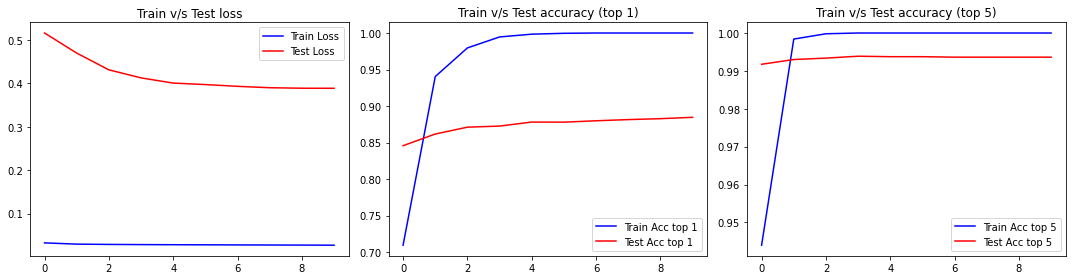

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

# Plot train and test loss
axs[0].plot(train_losses_rms_def,'b-', label='Train Loss')
axs[0].plot(test_losses_rms_def,'r-', label='Test Loss')
axs[0].set_title('Train v/s Test loss')
axs[0].legend()

# Plot top 1 train and test accuracy
axs[1].plot(train_accuracies_top1_rms_def,'b-', label='Train Acc top 1')
axs[1].plot(test_accuracies_top1_rms_def,'r-', label='Test Acc top 1')
axs[1].set_title('Train v/s Test accuracy (top 1)')
axs[1].legend()

# Plot top 5 train and test accuracy
axs[2].plot(train_accuracied_top5_rms_def,'b-', label='Train Acc top 5')
axs[2].plot(test_accuracies_top5_rms_def,'r-', label='Test Acc top 5')
axs[2].set_title('Train v/s Test accuracy (top 5)')
axs[2].legend()

plt.tight_layout()
plt.show()


## Trying diff hyperparameters for Adam

### varying beta1

In [ ]:
# Define optimizer and learning rate scheduler
n_epochs = 5
lr = 3e-5
betas = [(0.9, 0.999), (0.8, 0.999), (0.7, 0.999), (0.6, 0.999), (0.5, 0.999)]
momentums = [0.9, 0.8, 0.7, 0.6, 0.5]

top5_accuracies = []

for beta1 in betas:
    optimizer = optim.Adam(resnet_adam.parameters(), lr=lr, betas=beta1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Train and evaluate model
    train_losses_adam = []
    test_losses_adam = []
    train_accuracies_top1_adam = []
    test_accuracies_top1_adam = []
    train_accuracies_top5_adam = []
    test_accuracies_top5_adam = []
    for epoch in range(n_epochs):
        train_loss, train_acc_top1, train_acc_top5 = train(model, device, train_loader, optimizer, epoch, 0.001)
        test_loss, test_acc_top1, test_acc_top5 = test(model, device, test_loader, 0.001)
        train_losses_adam.append(train_loss)
        train_accuracies_top1_adam.append(train_acc_top1)
        train_accuracies_top5_adam.append(train_acc_top5)
        test_losses_adam.append(test_loss)
        test_accuracies_top1_adam.append(test_acc_top1)
        test_accuracies_top5_adam.append(test_acc_top5)
        print()
        print("Epoch: ", epoch + 1, "Train Loss: ", train_loss, "Train Acc top 1: ", train_acc_top1.item(), "Test Loss: ", test_loss, "Test Acc top 1: ", test_acc_top1)
        print("Train Acc top 5: ", train_acc_top5.item(), "Test Acc top 5: ", test_acc_top5)
        print()

    top5_accuracies.append(test_accuracies_top5_adam)


Testing: 100%|██████████| 32/32 [00:06<00:00,  4.94batch/s, loss=97.3]



Epoch:  1 Train Loss:  0.02724129762649536 Train Acc top 1:  1.0 Test Loss:  0.3891538829803467 Test Acc top 1:  0.88425
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.99batch/s, loss=97.2]



Epoch:  2 Train Loss:  0.027242316341400147 Train Acc top 1:  1.0 Test Loss:  0.38887863683700563 Test Acc top 1:  0.884
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.93batch/s, loss=97.2]



Epoch:  3 Train Loss:  0.027241388893127442 Train Acc top 1:  1.0 Test Loss:  0.38881601476669314 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.82batch/s, loss=97.3]



Epoch:  4 Train Loss:  0.02724251432418823 Train Acc top 1:  1.0 Test Loss:  0.38931509733200076 Test Acc top 1:  0.884625
Train Acc top 5:  1.0 Test Acc top 5:  0.993875



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.78batch/s, loss=97]



Epoch:  5 Train Loss:  0.027242858219146727 Train Acc top 1:  1.0 Test Loss:  0.3880195517539978 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.81batch/s, loss=97.1]



Epoch:  1 Train Loss:  0.027245247268676758 Train Acc top 1:  1.0 Test Loss:  0.38839891195297244 Test Acc top 1:  0.883375
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.66batch/s, loss=97.2]



Epoch:  2 Train Loss:  0.02724034004211426 Train Acc top 1:  1.0 Test Loss:  0.3887884030342102 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.56batch/s, loss=96.8]



Epoch:  3 Train Loss:  0.02724153242111206 Train Acc top 1:  1.0 Test Loss:  0.3873363103866577 Test Acc top 1:  0.884625
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.65batch/s, loss=97]



Epoch:  4 Train Loss:  0.027241315269470216 Train Acc top 1:  1.0 Test Loss:  0.3880467839241028 Test Acc top 1:  0.883875
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.50batch/s, loss=97.3]



Epoch:  5 Train Loss:  0.027243184089660644 Train Acc top 1:  1.0 Test Loss:  0.3891798658370972 Test Acc top 1:  0.884625
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.49batch/s, loss=97.2]



Epoch:  1 Train Loss:  0.027241819190979004 Train Acc top 1:  1.0 Test Loss:  0.3886373410224915 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.99325



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.13batch/s, loss=97.2]



Epoch:  2 Train Loss:  0.027241601181030275 Train Acc top 1:  1.0 Test Loss:  0.38872813510894777 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.56batch/s, loss=97.4]



Epoch:  3 Train Loss:  0.02724282646179199 Train Acc top 1:  1.0 Test Loss:  0.38945683431625366 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.74batch/s, loss=97.1]



Epoch:  4 Train Loss:  0.027241363334655763 Train Acc top 1:  1.0 Test Loss:  0.3882806053161621 Test Acc top 1:  0.883875
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.84batch/s, loss=97.1]



Epoch:  5 Train Loss:  0.027240603637695312 Train Acc top 1:  1.0 Test Loss:  0.3882894020080566 Test Acc top 1:  0.885375
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.96batch/s, loss=97.2]



Epoch:  1 Train Loss:  0.02724343891143799 Train Acc top 1:  1.0 Test Loss:  0.38874997329711913 Test Acc top 1:  0.884375
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.00batch/s, loss=97.4]



Epoch:  2 Train Loss:  0.027241983032226563 Train Acc top 1:  1.0 Test Loss:  0.38961933279037475 Test Acc top 1:  0.883375
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.05batch/s, loss=97.4]



Epoch:  3 Train Loss:  0.027241398334503175 Train Acc top 1:  1.0 Test Loss:  0.38940245485305786 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.99325



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.93batch/s, loss=97.1]



Epoch:  4 Train Loss:  0.027243093490600587 Train Acc top 1:  1.0 Test Loss:  0.3883568429946899 Test Acc top 1:  0.8835
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.87batch/s, loss=97]



Epoch:  5 Train Loss:  0.027242055225372316 Train Acc top 1:  1.0 Test Loss:  0.3881305856704712 Test Acc top 1:  0.885
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.93batch/s, loss=97.3]



Epoch:  1 Train Loss:  0.027242385482788085 Train Acc top 1:  1.0 Test Loss:  0.3893789916038513 Test Acc top 1:  0.8835
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.78batch/s, loss=97.4]



Epoch:  2 Train Loss:  0.02724061698913574 Train Acc top 1:  1.0 Test Loss:  0.389554829120636 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.71batch/s, loss=97.1]



Epoch:  3 Train Loss:  0.02724130687713623 Train Acc top 1:  1.0 Test Loss:  0.388307044506073 Test Acc top 1:  0.883625
Train Acc top 5:  1.0 Test Acc top 5:  0.993125



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.58batch/s, loss=97.2]



Epoch:  4 Train Loss:  0.027242312717437746 Train Acc top 1:  1.0 Test Loss:  0.38890995836257936 Test Acc top 1:  0.884875
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.65batch/s, loss=97.2]


Epoch:  5 Train Loss:  0.02724215860366821 Train Acc top 1:  1.0 Test Loss:  0.3889696297645569 Test Acc top 1:  0.884875
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



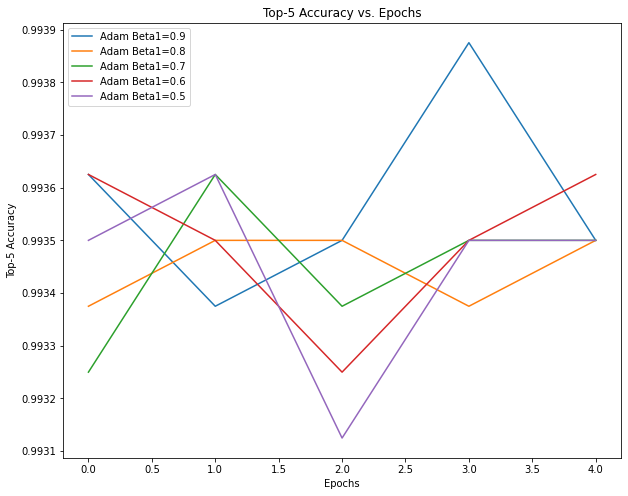

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(betas)):
    ax.plot(top5_accuracies[i], label=f'Adam Beta1={betas[i][0]}')

ax.set_title('Top-5 Accuracy vs. Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Top-5 Accuracy')
ax.legend()
plt.show()


### varying beta2

In [ ]:
# Define optimizer and learning rate scheduler
n_epochs = 5
lr = 3e-5
betas = [(0.9, 0.999), (0.9, 0.9), (0.9, 0.8), (0.9, 0.7), (0.9, 0.6)]

top_5_acc_beta2 = []

for beta1 in betas:
    optimizer = optim.Adam(resnet_adam.parameters(), lr=lr, betas=beta1)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Train and evaluate model
    train_losses_adam = []
    test_losses_adam = []
    train_accuracies_top1_adam = []
    test_accuracies_top1_adam = []
    train_accuracies_top5_adam = []
    test_accuracies_top5_adam = []
    for epoch in range(n_epochs):
        train_loss, train_acc_top1, train_acc_top5 = train(model, device, train_loader, optimizer, epoch, 0.001)
        test_loss, test_acc_top1, test_acc_top5 = test(model, device, test_loader, 0.001)
        train_losses_adam.append(train_loss)
        train_accuracies_top1_adam.append(train_acc_top1)
        train_accuracies_top5_adam.append(train_acc_top5)
        test_losses_adam.append(test_loss)
        test_accuracies_top1_adam.append(test_acc_top1)
        test_accuracies_top5_adam.append(test_acc_top5)
        print()
        print("Epoch: ", epoch + 1, "Train Loss: ", train_loss, "Train Acc top 1: ", train_acc_top1.item(), "Test Loss: ", test_loss, "Test Acc top 1: ", test_acc_top1)
        print("Train Acc top 5: ", train_acc_top5.item(), "Test Acc top 5: ", test_acc_top5)
        print()

    top_5_acc_beta2.append(test_accuracies_top5_adam)


Testing: 100%|██████████| 32/32 [00:07<00:00,  4.17batch/s, loss=97.3]



Epoch:  1 Train Loss:  0.027240324783325196 Train Acc top 1:  1.0 Test Loss:  0.3893524751663208 Test Acc top 1:  0.8845
Train Acc top 5:  1.0 Test Acc top 5:  0.99325



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.49batch/s, loss=96.9]



Epoch:  2 Train Loss:  0.027241325283050538 Train Acc top 1:  1.0 Test Loss:  0.38770180559158324 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.50batch/s, loss=96.9]



Epoch:  3 Train Loss:  0.027241869735717773 Train Acc top 1:  1.0 Test Loss:  0.3876639275550842 Test Acc top 1:  0.884375
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.60batch/s, loss=97.1]



Epoch:  4 Train Loss:  0.027242132091522216 Train Acc top 1:  1.0 Test Loss:  0.3884743714332581 Test Acc top 1:  0.88325
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.75batch/s, loss=97.2]



Epoch:  5 Train Loss:  0.02724227352142334 Train Acc top 1:  1.0 Test Loss:  0.38866579484939573 Test Acc top 1:  0.8835
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.81batch/s, loss=97.2]



Epoch:  1 Train Loss:  0.02724173011779785 Train Acc top 1:  1.0 Test Loss:  0.3888654923439026 Test Acc top 1:  0.88325
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.01batch/s, loss=97.1]



Epoch:  2 Train Loss:  0.02724087791442871 Train Acc top 1:  1.0 Test Loss:  0.38841063690185545 Test Acc top 1:  0.884875
Train Acc top 5:  1.0 Test Acc top 5:  0.993875



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.88batch/s, loss=97.2]



Epoch:  3 Train Loss:  0.027239142608642578 Train Acc top 1:  1.0 Test Loss:  0.38893148183822635 Test Acc top 1:  0.882875
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.02batch/s, loss=97]



Epoch:  4 Train Loss:  0.02724114990234375 Train Acc top 1:  1.0 Test Loss:  0.3880068111419678 Test Acc top 1:  0.88425
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.01batch/s, loss=97.2]



Epoch:  5 Train Loss:  0.027240718650817872 Train Acc top 1:  1.0 Test Loss:  0.38892691802978513 Test Acc top 1:  0.88425
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.01batch/s, loss=97]



Epoch:  1 Train Loss:  0.027241097831726076 Train Acc top 1:  1.0 Test Loss:  0.38780244255065915 Test Acc top 1:  0.885
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.96batch/s, loss=97.3]



Epoch:  2 Train Loss:  0.027242525672912597 Train Acc top 1:  1.0 Test Loss:  0.3891848797798157 Test Acc top 1:  0.88475
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.01batch/s, loss=97.4]



Epoch:  3 Train Loss:  0.027242682456970216 Train Acc top 1:  1.0 Test Loss:  0.38974855518341067 Test Acc top 1:  0.8835
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.86batch/s, loss=96.8]



Epoch:  4 Train Loss:  0.02724244270324707 Train Acc top 1:  1.0 Test Loss:  0.387365939617157 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.993875



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.76batch/s, loss=97.1]



Epoch:  5 Train Loss:  0.027240669918060303 Train Acc top 1:  1.0 Test Loss:  0.38859727811813355 Test Acc top 1:  0.883875
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.53batch/s, loss=96.9]



Epoch:  1 Train Loss:  0.02724248914718628 Train Acc top 1:  1.0 Test Loss:  0.3875611958503723 Test Acc top 1:  0.883625
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.56batch/s, loss=97.2]



Epoch:  2 Train Loss:  0.027240752506256103 Train Acc top 1:  1.0 Test Loss:  0.3888588480949402 Test Acc top 1:  0.8845
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.51batch/s, loss=97.5]



Epoch:  3 Train Loss:  0.02724290885925293 Train Acc top 1:  1.0 Test Loss:  0.3900581254959106 Test Acc top 1:  0.88475
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.51batch/s, loss=97.2]



Epoch:  4 Train Loss:  0.02724246664047241 Train Acc top 1:  1.0 Test Loss:  0.3887910213470459 Test Acc top 1:  0.88425
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.50batch/s, loss=97]



Epoch:  5 Train Loss:  0.02724134883880615 Train Acc top 1:  1.0 Test Loss:  0.3880109148025513 Test Acc top 1:  0.884625
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.45batch/s, loss=97.2]



Epoch:  1 Train Loss:  0.027240971755981447 Train Acc top 1:  1.0 Test Loss:  0.3887626094818115 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.53batch/s, loss=97.1]



Epoch:  2 Train Loss:  0.02724097080230713 Train Acc top 1:  1.0 Test Loss:  0.3882822313308716 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.993125



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.88batch/s, loss=97.4]



Epoch:  3 Train Loss:  0.0272431001663208 Train Acc top 1:  1.0 Test Loss:  0.3894285144805908 Test Acc top 1:  0.883875
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.92batch/s, loss=97.1]



Epoch:  4 Train Loss:  0.027240975856781004 Train Acc top 1:  1.0 Test Loss:  0.38838848304748536 Test Acc top 1:  0.884875
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.95batch/s, loss=97.1]


Epoch:  5 Train Loss:  0.027241185760498048 Train Acc top 1:  1.0 Test Loss:  0.3882832260131836 Test Acc top 1:  0.88425
Train Acc top 5:  1.0 Test Acc top 5:  0.99325



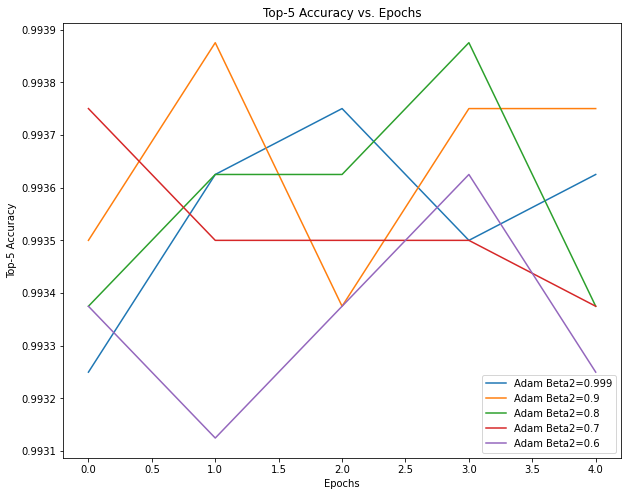

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(betas)):
    ax.plot(top_5_acc_beta2[i], label=f'Adam Beta2={betas[i][1]}')

ax.set_title('Top-5 Accuracy vs. Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Top-5 Accuracy')
ax.legend()
plt.show()


### varying weight decay

In [ ]:
# Define optimizer and learning rate scheduler
n_epochs = 5
lr = 3e-5
weight_decays = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

top_5_acc_wd = []

for wd in weight_decays:
    optimizer = optim.Adam(resnet_adam.parameters(), lr=lr, weight_decay=wd)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Train and evaluate model
    train_losses_adam = []
    test_losses_adam = []
    train_accuracies_top1_adam = []
    test_accuracies_top1_adam = []
    train_accuracies_top5_adam = []
    test_accuracies_top5_adam = []
    for epoch in range(n_epochs):
        train_loss, train_acc_top1, train_acc_top5 = train(model, device, train_loader, optimizer, epoch, 0.001)
        test_loss, test_acc_top1, test_acc_top5 = test(model, device, test_loader, 0.001)
        train_losses_adam.append(train_loss)
        train_accuracies_top1_adam.append(train_acc_top1)
        train_accuracies_top5_adam.append(train_acc_top5)
        test_losses_adam.append(test_loss)
        test_accuracies_top1_adam.append(test_acc_top1)
        test_accuracies_top5_adam.append(test_acc_top5)
        print()
        print("Epoch: ", epoch + 1, "Train Loss: ", train_loss, "Train Acc top 1: ", train_acc_top1.item(), "Test Loss: ", test_loss, "Test Acc top 1: ", test_acc_top1)
        print("Train Acc top 5: ", train_acc_top5.item(), "Test Acc top 5: ", test_acc_top5)
        print()

    top_5_acc_wd.append(test_accuracies_top5_adam)


Testing: 100%|██████████| 32/32 [00:06<00:00,  5.03batch/s, loss=97.2]



Epoch:  1 Train Loss:  0.02724209623336792 Train Acc top 1:  1.0 Test Loss:  0.38886974906921384 Test Acc top 1:  0.884625
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.12batch/s, loss=97.1]



Epoch:  2 Train Loss:  0.027241119289398194 Train Acc top 1:  1.0 Test Loss:  0.3883294858932495 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.05batch/s, loss=97.4]



Epoch:  3 Train Loss:  0.02724292964935303 Train Acc top 1:  1.0 Test Loss:  0.38971685886383056 Test Acc top 1:  0.8835
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.97batch/s, loss=97.3]



Epoch:  4 Train Loss:  0.027240808868408205 Train Acc top 1:  1.0 Test Loss:  0.3890215516090393 Test Acc top 1:  0.883375
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.00batch/s, loss=97.3]



Epoch:  5 Train Loss:  0.02724308633804321 Train Acc top 1:  1.0 Test Loss:  0.3892315654754639 Test Acc top 1:  0.883375
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.83batch/s, loss=97.1]



Epoch:  1 Train Loss:  0.027241753387451172 Train Acc top 1:  1.0 Test Loss:  0.38835596036911013 Test Acc top 1:  0.883625
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.66batch/s, loss=96.8]



Epoch:  2 Train Loss:  0.027243535041809083 Train Acc top 1:  1.0 Test Loss:  0.3871988425254822 Test Acc top 1:  0.883375
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.69batch/s, loss=96.8]



Epoch:  3 Train Loss:  0.027241342449188233 Train Acc top 1:  1.0 Test Loss:  0.3873350410461426 Test Acc top 1:  0.884375
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.68batch/s, loss=97.3]



Epoch:  4 Train Loss:  0.027240797805786133 Train Acc top 1:  1.0 Test Loss:  0.38937929153442385 Test Acc top 1:  0.883
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.61batch/s, loss=97.2]



Epoch:  5 Train Loss:  0.027241427993774416 Train Acc top 1:  1.0 Test Loss:  0.38897967290878294 Test Acc top 1:  0.88275
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.60batch/s, loss=97.2]



Epoch:  1 Train Loss:  0.027242953395843508 Train Acc top 1:  1.0 Test Loss:  0.38861812496185305 Test Acc top 1:  0.884
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.56batch/s, loss=96.8]



Epoch:  2 Train Loss:  0.02724130916595459 Train Acc top 1:  1.0 Test Loss:  0.3870369920730591 Test Acc top 1:  0.884375
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.58batch/s, loss=97.2]



Epoch:  3 Train Loss:  0.02724116086959839 Train Acc top 1:  1.0 Test Loss:  0.3886907558441162 Test Acc top 1:  0.883875
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.56batch/s, loss=97.2]



Epoch:  4 Train Loss:  0.02724199514389038 Train Acc top 1:  1.0 Test Loss:  0.3887616543769836 Test Acc top 1:  0.8845
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.53batch/s, loss=97.1]



Epoch:  5 Train Loss:  0.02724122371673584 Train Acc top 1:  1.0 Test Loss:  0.38847855377197266 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.80batch/s, loss=97]



Epoch:  1 Train Loss:  0.027241735649108888 Train Acc top 1:  1.0 Test Loss:  0.3878774619102478 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.87batch/s, loss=97.3]



Epoch:  2 Train Loss:  0.027240972423553465 Train Acc top 1:  1.0 Test Loss:  0.3891367621421814 Test Acc top 1:  0.883625
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.03batch/s, loss=96.9]



Epoch:  3 Train Loss:  0.02724128532409668 Train Acc top 1:  1.0 Test Loss:  0.3875221953392029 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.71batch/s, loss=97.2]



Epoch:  4 Train Loss:  0.027242149162292482 Train Acc top 1:  1.0 Test Loss:  0.3888622670173645 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.06batch/s, loss=97]



Epoch:  5 Train Loss:  0.027241857624053956 Train Acc top 1:  1.0 Test Loss:  0.3879115319252014 Test Acc top 1:  0.8835
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.00batch/s, loss=97.5]



Epoch:  1 Train Loss:  0.027243022155761718 Train Acc top 1:  1.0 Test Loss:  0.38989766979217527 Test Acc top 1:  0.8825
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.09batch/s, loss=97.4]



Epoch:  2 Train Loss:  0.02724154453277588 Train Acc top 1:  1.0 Test Loss:  0.3894502100944519 Test Acc top 1:  0.883375
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.99batch/s, loss=97.2]



Epoch:  3 Train Loss:  0.02724093770980835 Train Acc top 1:  1.0 Test Loss:  0.3886432828903198 Test Acc top 1:  0.884
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.94batch/s, loss=96.8]



Epoch:  4 Train Loss:  0.027242461585998533 Train Acc top 1:  1.0 Test Loss:  0.3871230382919312 Test Acc top 1:  0.884875
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.80batch/s, loss=96.9]


Epoch:  5 Train Loss:  0.027240780925750732 Train Acc top 1:  1.0 Test Loss:  0.387661732673645 Test Acc top 1:  0.8845
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



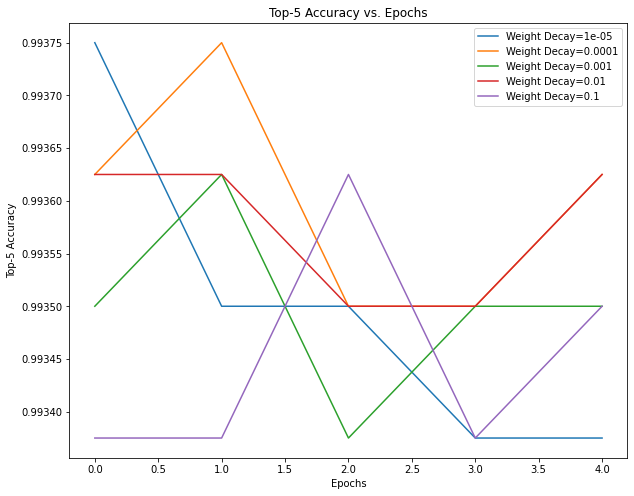

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(weight_decays)):
    ax.plot(top_5_acc_wd[i], label=f'Weight Decay={weight_decays[i]}')

ax.set_title('Top-5 Accuracy vs. Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Top-5 Accuracy')
ax.legend()
plt.show()

### varying learning rate

In [ ]:
# Define optimizer and learning rate scheduler
n_epochs = 5
learning_rates = [0.1,0.01,0.001,0.0001,0.00001]

top_5_acc_lr = []

for LR in learning_rates:
    optimizer = optim.Adam(resnet_adam.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Train and evaluate model
    train_losses_adam = []
    test_losses_adam = []
    train_accuracies_top1_adam = []
    test_accuracies_top1_adam = []
    train_accuracies_top5_adam = []
    test_accuracies_top5_adam = []
    for epoch in range(n_epochs):
        train_loss, train_acc_top1, train_acc_top5 = train(model, device, train_loader, optimizer, epoch, 0.001)
        test_loss, test_acc_top1, test_acc_top5 = test(model, device, test_loader, 0.001)
        train_losses_adam.append(train_loss)
        train_accuracies_top1_adam.append(train_acc_top1)
        train_accuracies_top5_adam.append(train_acc_top5)
        test_losses_adam.append(test_loss)
        test_accuracies_top1_adam.append(test_acc_top1)
        test_accuracies_top5_adam.append(test_acc_top5)
        print()
        print("Epoch: ", epoch + 1, "Train Loss: ", train_loss, "Train Acc top 1: ", train_acc_top1.item(), "Test Loss: ", test_loss, "Test Acc top 1: ", test_acc_top1)
        print("Train Acc top 5: ", train_acc_top5.item(), "Test Acc top 5: ", test_acc_top5)
        print()

    top_5_acc_lr.append(test_accuracies_top5_adam)


Testing: 100%|██████████| 32/32 [00:06<00:00,  4.76batch/s, loss=97.1]



Epoch:  1 Train Loss:  0.027239954948425293 Train Acc top 1:  1.0 Test Loss:  0.38846277666091916 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.67batch/s, loss=97.2]



Epoch:  2 Train Loss:  0.02724057502746582 Train Acc top 1:  1.0 Test Loss:  0.38898243713378905 Test Acc top 1:  0.88475
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.66batch/s, loss=97.2]



Epoch:  3 Train Loss:  0.027243384838104248 Train Acc top 1:  1.0 Test Loss:  0.38868840026855467 Test Acc top 1:  0.883625
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.60batch/s, loss=97.1]



Epoch:  4 Train Loss:  0.027240001106262207 Train Acc top 1:  1.0 Test Loss:  0.38857282733917237 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.60batch/s, loss=97.4]



Epoch:  5 Train Loss:  0.027242663383483887 Train Acc top 1:  1.0 Test Loss:  0.38955147075653074 Test Acc top 1:  0.883625
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.55batch/s, loss=97.3]



Epoch:  1 Train Loss:  0.027240708827972412 Train Acc top 1:  1.0 Test Loss:  0.38917534828186034 Test Acc top 1:  0.88425
Train Acc top 5:  1.0 Test Acc top 5:  0.993125



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.58batch/s, loss=97.1]



Epoch:  2 Train Loss:  0.027242290496826173 Train Acc top 1:  1.0 Test Loss:  0.3883712863922119 Test Acc top 1:  0.88525
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.43batch/s, loss=97.1]



Epoch:  3 Train Loss:  0.027241413307189943 Train Acc top 1:  1.0 Test Loss:  0.3882418112754822 Test Acc top 1:  0.884375
Train Acc top 5:  1.0 Test Acc top 5:  0.99325



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.61batch/s, loss=97]



Epoch:  4 Train Loss:  0.02724167432785034 Train Acc top 1:  1.0 Test Loss:  0.3881985597610474 Test Acc top 1:  0.883375
Train Acc top 5:  1.0 Test Acc top 5:  0.993875



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.81batch/s, loss=97.2]



Epoch:  5 Train Loss:  0.027242507362365723 Train Acc top 1:  1.0 Test Loss:  0.3888468608856201 Test Acc top 1:  0.88325
Train Acc top 5:  1.0 Test Acc top 5:  0.993125



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.98batch/s, loss=97.2]



Epoch:  1 Train Loss:  0.027240730094909668 Train Acc top 1:  1.0 Test Loss:  0.38883471488952637 Test Acc top 1:  0.884
Train Acc top 5:  1.0 Test Acc top 5:  0.99325



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.12batch/s, loss=97.2]



Epoch:  2 Train Loss:  0.027241549110412596 Train Acc top 1:  1.0 Test Loss:  0.3886636047363281 Test Acc top 1:  0.883875
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.95batch/s, loss=97.3]



Epoch:  3 Train Loss:  0.027242826366424562 Train Acc top 1:  1.0 Test Loss:  0.3891437525749207 Test Acc top 1:  0.8825
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.12batch/s, loss=96.9]



Epoch:  4 Train Loss:  0.02724077787399292 Train Acc top 1:  1.0 Test Loss:  0.3877612361907959 Test Acc top 1:  0.884625
Train Acc top 5:  1.0 Test Acc top 5:  0.99325



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.15batch/s, loss=97.4]



Epoch:  5 Train Loss:  0.02724065351486206 Train Acc top 1:  1.0 Test Loss:  0.38949868392944337 Test Acc top 1:  0.884
Train Acc top 5:  1.0 Test Acc top 5:  0.993875



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.02batch/s, loss=97.6]



Epoch:  1 Train Loss:  0.0272417706489563 Train Acc top 1:  1.0 Test Loss:  0.39027402639389036 Test Acc top 1:  0.884
Train Acc top 5:  1.0 Test Acc top 5:  0.99325



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.99batch/s, loss=97]



Epoch:  2 Train Loss:  0.027240120315551758 Train Acc top 1:  1.0 Test Loss:  0.3881445560455322 Test Acc top 1:  0.883375
Train Acc top 5:  1.0 Test Acc top 5:  0.993875



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.15batch/s, loss=96.9]



Epoch:  3 Train Loss:  0.027242379093170167 Train Acc top 1:  1.0 Test Loss:  0.38745878887176516 Test Acc top 1:  0.88425
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.12batch/s, loss=97.1]



Epoch:  4 Train Loss:  0.02724097318649292 Train Acc top 1:  1.0 Test Loss:  0.388323751449585 Test Acc top 1:  0.8845
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.10batch/s, loss=97.2]



Epoch:  5 Train Loss:  0.027242068195343017 Train Acc top 1:  1.0 Test Loss:  0.3889656758308411 Test Acc top 1:  0.884375
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.07batch/s, loss=97.3]



Epoch:  1 Train Loss:  0.02724225845336914 Train Acc top 1:  1.0 Test Loss:  0.38924087190628054 Test Acc top 1:  0.8845
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.46batch/s, loss=97.2]



Epoch:  2 Train Loss:  0.027242351818084716 Train Acc top 1:  1.0 Test Loss:  0.38865882444381716 Test Acc top 1:  0.883625
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.69batch/s, loss=97.2]



Epoch:  3 Train Loss:  0.02724382791519165 Train Acc top 1:  1.0 Test Loss:  0.3888773546218872 Test Acc top 1:  0.885
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.60batch/s, loss=97.2]



Epoch:  4 Train Loss:  0.027242758464813232 Train Acc top 1:  1.0 Test Loss:  0.3887896800041199 Test Acc top 1:  0.884375
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.64batch/s, loss=96.9]


Epoch:  5 Train Loss:  0.027241709899902343 Train Acc top 1:  1.0 Test Loss:  0.3877575492858887 Test Acc top 1:  0.88325
Train Acc top 5:  1.0 Test Acc top 5:  0.994



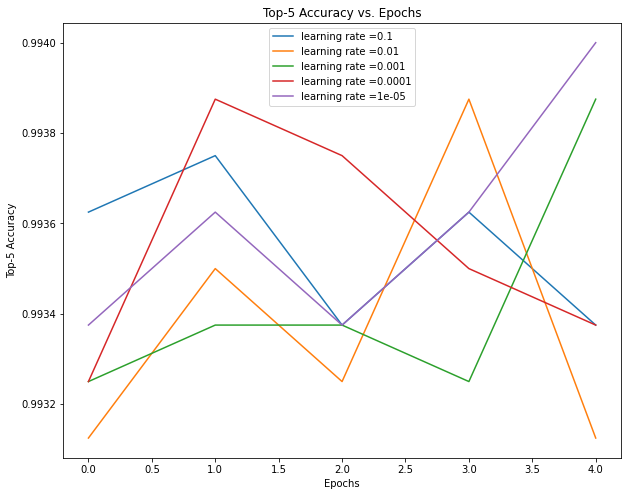

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(learning_rates)):
    ax.plot(top_5_acc_lr[i], label=f'learning rate ={learning_rates[i]}')

ax.set_title('Top-5 Accuracy vs. Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Top-5 Accuracy')
ax.legend()
plt.show()

## Trying diff Hyperparameters for Adagrad

### varying weight decay

In [ ]:
# Define optimizer and learning rate scheduler
n_epochs = 5
lr = 3e-5
weight_decays = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

top_5_acc_wd_adagrad = []

for wd in weight_decays:
    optimizer = optim.Adagrad(resnet_adagrad.parameters(), lr=lr, weight_decay = wd)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Train and evaluate model
    train_losses_adagrad = []
    test_losses_adagrad = []
    train_accuracies_top1_adagrad = []
    test_accuracies_top1_adagrad = []
    train_accuracies_top5_adagrad = []
    test_accuracies_top5_adagrad = []
    for epoch in range(n_epochs):
        train_loss, train_acc_top1, train_acc_top5 = train(model, device, train_loader, optimizer, epoch, 0.001)
        test_loss, test_acc_top1, test_acc_top5 = test(model, device, test_loader, 0.001)
        train_losses_adagrad.append(train_loss)
        train_accuracies_top1_adagrad.append(train_acc_top1)
        train_accuracies_top5_adagrad.append(train_acc_top5)
        test_losses_adagrad.append(test_loss)
        test_accuracies_top1_adagrad.append(test_acc_top1)
        test_accuracies_top5_adagrad.append(test_acc_top5)
        print()
        print("Epoch: ", epoch + 1, "Train Loss: ", train_loss, "Train Acc top 1: ", train_acc_top1.item(), "Test Loss: ", test_loss, "Test Acc top 1: ", test_acc_top1)
        print("Train Acc top 5: ", train_acc_top5.item(), "Test Acc top 5: ", test_acc_top5)
        print()

    top_5_acc_wd_adagrad.append(test_accuracies_top5_adagrad)


Testing: 100%|██████████| 32/32 [00:06<00:00,  4.70batch/s, loss=97.3]



Epoch:  1 Train Loss:  0.02724202661514282 Train Acc top 1:  1.0 Test Loss:  0.3892676792144775 Test Acc top 1:  0.883625
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.74batch/s, loss=97.1]



Epoch:  2 Train Loss:  0.027240527057647707 Train Acc top 1:  1.0 Test Loss:  0.38841034269332886 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.61batch/s, loss=97.7]



Epoch:  3 Train Loss:  0.027242230796813965 Train Acc top 1:  1.0 Test Loss:  0.3908754029273987 Test Acc top 1:  0.882125
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.59batch/s, loss=97.2]



Epoch:  4 Train Loss:  0.027241292095184326 Train Acc top 1:  1.0 Test Loss:  0.38878441524505614 Test Acc top 1:  0.884625
Train Acc top 5:  1.0 Test Acc top 5:  0.99325



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.58batch/s, loss=97.4]



Epoch:  5 Train Loss:  0.02724431505203247 Train Acc top 1:  1.0 Test Loss:  0.3895000128746033 Test Acc top 1:  0.883375
Train Acc top 5:  1.0 Test Acc top 5:  0.993125



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.50batch/s, loss=97]



Epoch:  1 Train Loss:  0.0272420334815979 Train Acc top 1:  1.0 Test Loss:  0.38818363189697264 Test Acc top 1:  0.884
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.52batch/s, loss=97]



Epoch:  2 Train Loss:  0.027243039989471435 Train Acc top 1:  1.0 Test Loss:  0.388067599773407 Test Acc top 1:  0.884875
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.53batch/s, loss=97.2]



Epoch:  3 Train Loss:  0.02724322681427002 Train Acc top 1:  1.0 Test Loss:  0.3887057538032532 Test Acc top 1:  0.884625
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.73batch/s, loss=96.9]



Epoch:  4 Train Loss:  0.02724158458709717 Train Acc top 1:  1.0 Test Loss:  0.38755873107910155 Test Acc top 1:  0.88475
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.88batch/s, loss=97.1]



Epoch:  5 Train Loss:  0.027241590118408203 Train Acc top 1:  1.0 Test Loss:  0.38858904361724855 Test Acc top 1:  0.883625
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.49batch/s, loss=97.4]



Epoch:  1 Train Loss:  0.027245207023620606 Train Acc top 1:  0.9998 Test Loss:  0.38976900100708006 Test Acc top 1:  0.88425
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.07batch/s, loss=97.5]



Epoch:  2 Train Loss:  0.0272404541015625 Train Acc top 1:  1.0 Test Loss:  0.3898322949409485 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.05batch/s, loss=97.3]



Epoch:  3 Train Loss:  0.02724175453186035 Train Acc top 1:  1.0 Test Loss:  0.389352071762085 Test Acc top 1:  0.884625
Train Acc top 5:  1.0 Test Acc top 5:  0.99325



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.17batch/s, loss=97.2]



Epoch:  4 Train Loss:  0.02724169864654541 Train Acc top 1:  1.0 Test Loss:  0.38872154474258425 Test Acc top 1:  0.8835
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.13batch/s, loss=97.1]



Epoch:  5 Train Loss:  0.02724146432876587 Train Acc top 1:  1.0 Test Loss:  0.38857207298278806 Test Acc top 1:  0.88425
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.04batch/s, loss=97.5]



Epoch:  1 Train Loss:  0.027244278812408446 Train Acc top 1:  1.0 Test Loss:  0.3899052562713623 Test Acc top 1:  0.8835
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.99batch/s, loss=96.9]



Epoch:  2 Train Loss:  0.027240416717529296 Train Acc top 1:  1.0 Test Loss:  0.38772053813934326 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.03batch/s, loss=97]



Epoch:  3 Train Loss:  0.027240475463867188 Train Acc top 1:  1.0 Test Loss:  0.3879738063812256 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.20batch/s, loss=97.1]



Epoch:  4 Train Loss:  0.02724008016586304 Train Acc top 1:  1.0 Test Loss:  0.3884636526107788 Test Acc top 1:  0.88425
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.14batch/s, loss=97.1]



Epoch:  5 Train Loss:  0.027241926002502442 Train Acc top 1:  1.0 Test Loss:  0.38820872783660887 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.10batch/s, loss=97.3]



Epoch:  1 Train Loss:  0.027241620540618898 Train Acc top 1:  1.0 Test Loss:  0.389082603931427 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.00batch/s, loss=97.2]



Epoch:  2 Train Loss:  0.027241227912902833 Train Acc top 1:  1.0 Test Loss:  0.3887414793968201 Test Acc top 1:  0.88325
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.97batch/s, loss=97.2]



Epoch:  3 Train Loss:  0.027241457557678223 Train Acc top 1:  1.0 Test Loss:  0.3887001962661743 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.85batch/s, loss=97.2]



Epoch:  4 Train Loss:  0.02724159469604492 Train Acc top 1:  1.0 Test Loss:  0.3888530235290527 Test Acc top 1:  0.883875
Train Acc top 5:  1.0 Test Acc top 5:  0.99325



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.66batch/s, loss=97.4]


Epoch:  5 Train Loss:  0.027241224002838134 Train Acc top 1:  1.0 Test Loss:  0.38942493438720704 Test Acc top 1:  0.88425
Train Acc top 5:  1.0 Test Acc top 5:  0.99325



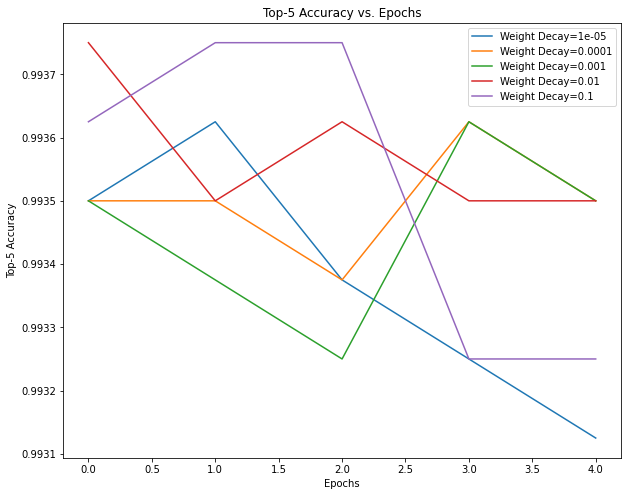

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(weight_decays)):
    ax.plot(top_5_acc_wd_adagrad[i], label=f'Weight Decay={weight_decays[i]}')

ax.set_title('Top-5 Accuracy vs. Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Top-5 Accuracy')
ax.legend()
plt.show()

### varying learning rates

In [ ]:
# Define optimizer and learning rate scheduler
n_epochs = 5
learning_rates = [0.1,0.01,0.001,0.0001,0.00001]

top5_acc_lr_adagrad = []

for LR in learning_rates:
    optimizer = optim.Adagrad(resnet_adagrad.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Train and evaluate model
    train_losses_adagrad = []
    test_losses_adagrad = []
    train_accuracies_top1_adagrad = []
    test_accuracies_top1_adagrad = []
    train_accuracies_top5_adagrad = []
    test_accuracies_top5_adagrad = []
    for epoch in range(n_epochs):
        train_loss, train_acc_top1, train_acc_top5 = train(model, device, train_loader, optimizer, epoch, 0.001)
        test_loss, test_acc_top1, test_acc_top5 = test(model, device, test_loader, 0.001)
        train_losses_adagrad.append(train_loss)
        train_accuracies_top1_adagrad.append(train_acc_top1)
        train_accuracies_top5_adagrad.append(train_acc_top5)
        test_losses_adagrad.append(test_loss)
        test_accuracies_top1_adagrad.append(test_acc_top1)
        test_accuracies_top5_adagrad.append(test_acc_top5)
        print()
        print("Epoch: ", epoch + 1, "Train Loss: ", train_loss, "Train Acc top 1: ", train_acc_top1.item(), "Test Loss: ", test_loss, "Test Acc top 1: ", test_acc_top1)
        print("Train Acc top 5: ", train_acc_top5.item(), "Test Acc top 5: ", test_acc_top5)
        print()

    top5_acc_lr_adagrad.append(test_accuracies_top5_adagrad)


Testing: 100%|██████████| 32/32 [00:06<00:00,  4.94batch/s, loss=97.1]



Epoch:  1 Train Loss:  0.0272408878326416 Train Acc top 1:  1.0 Test Loss:  0.3885622916221619 Test Acc top 1:  0.884375
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.88batch/s, loss=97.3]



Epoch:  2 Train Loss:  0.027242769527435304 Train Acc top 1:  1.0 Test Loss:  0.38909968519210814 Test Acc top 1:  0.88325
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.75batch/s, loss=97]



Epoch:  3 Train Loss:  0.02724155216217041 Train Acc top 1:  1.0 Test Loss:  0.3878349962234497 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.69batch/s, loss=96.8]



Epoch:  4 Train Loss:  0.027242380046844483 Train Acc top 1:  1.0 Test Loss:  0.3870450663566589 Test Acc top 1:  0.883875
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.58batch/s, loss=97.1]



Epoch:  5 Train Loss:  0.02724050416946411 Train Acc top 1:  1.0 Test Loss:  0.3884598278999329 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.62batch/s, loss=97.1]



Epoch:  1 Train Loss:  0.027240966796875 Train Acc top 1:  1.0 Test Loss:  0.3885710506439209 Test Acc top 1:  0.884
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.69batch/s, loss=97.4]



Epoch:  2 Train Loss:  0.027240427017211914 Train Acc top 1:  1.0 Test Loss:  0.38941399669647214 Test Acc top 1:  0.88425
Train Acc top 5:  1.0 Test Acc top 5:  0.993125



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.66batch/s, loss=97.2]



Epoch:  3 Train Loss:  0.027242824935913085 Train Acc top 1:  1.0 Test Loss:  0.3888857536315918 Test Acc top 1:  0.882875
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.57batch/s, loss=97.4]



Epoch:  4 Train Loss:  0.027243618965148927 Train Acc top 1:  1.0 Test Loss:  0.38951810455322267 Test Acc top 1:  0.883375
Train Acc top 5:  1.0 Test Acc top 5:  0.993125



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.62batch/s, loss=97.1]



Epoch:  5 Train Loss:  0.027241351222991945 Train Acc top 1:  1.0 Test Loss:  0.38854569482803347 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.52batch/s, loss=96.9]



Epoch:  1 Train Loss:  0.027242597103118896 Train Acc top 1:  1.0 Test Loss:  0.3876819195747375 Test Acc top 1:  0.884625
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.55batch/s, loss=97]



Epoch:  2 Train Loss:  0.027241332721710206 Train Acc top 1:  1.0 Test Loss:  0.38786495351791384 Test Acc top 1:  0.884625
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.52batch/s, loss=96.7]



Epoch:  3 Train Loss:  0.027240797233581544 Train Acc top 1:  1.0 Test Loss:  0.3869488558769226 Test Acc top 1:  0.88425
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.53batch/s, loss=97.1]



Epoch:  4 Train Loss:  0.02724086332321167 Train Acc top 1:  1.0 Test Loss:  0.3884460573196411 Test Acc top 1:  0.885
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.67batch/s, loss=97.3]



Epoch:  5 Train Loss:  0.02724129648208618 Train Acc top 1:  1.0 Test Loss:  0.38922032022476194 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.78batch/s, loss=97]



Epoch:  1 Train Loss:  0.02724211597442627 Train Acc top 1:  1.0 Test Loss:  0.388065628528595 Test Acc top 1:  0.884625
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.99batch/s, loss=97.3]



Epoch:  2 Train Loss:  0.027243218326568605 Train Acc top 1:  1.0 Test Loss:  0.3892087912559509 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.99375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.09batch/s, loss=97.2]



Epoch:  3 Train Loss:  0.027242311668395996 Train Acc top 1:  1.0 Test Loss:  0.3887812991142273 Test Acc top 1:  0.88425
Train Acc top 5:  1.0 Test Acc top 5:  0.99325



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.14batch/s, loss=97.2]



Epoch:  4 Train Loss:  0.027241198539733887 Train Acc top 1:  1.0 Test Loss:  0.38889776945114135 Test Acc top 1:  0.883625
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.07batch/s, loss=97]



Epoch:  5 Train Loss:  0.027241802501678465 Train Acc top 1:  1.0 Test Loss:  0.387804190158844 Test Acc top 1:  0.88525
Train Acc top 5:  1.0 Test Acc top 5:  0.993375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.04batch/s, loss=97.1]



Epoch:  1 Train Loss:  0.027241717529296876 Train Acc top 1:  1.0 Test Loss:  0.3885918836593628 Test Acc top 1:  0.88525
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.10batch/s, loss=97.1]



Epoch:  2 Train Loss:  0.02724029474258423 Train Acc top 1:  1.0 Test Loss:  0.38828224611282347 Test Acc top 1:  0.883625
Train Acc top 5:  1.0 Test Acc top 5:  0.993625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.97batch/s, loss=97.4]



Epoch:  3 Train Loss:  0.02724203882217407 Train Acc top 1:  1.0 Test Loss:  0.3896516437530518 Test Acc top 1:  0.88375
Train Acc top 5:  1.0 Test Acc top 5:  0.99325



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.04batch/s, loss=97.1]



Epoch:  4 Train Loss:  0.027240036487579347 Train Acc top 1:  1.0 Test Loss:  0.38837415409088133 Test Acc top 1:  0.884125
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.05batch/s, loss=97]


Epoch:  5 Train Loss:  0.027240611457824707 Train Acc top 1:  1.0 Test Loss:  0.38802118349075315 Test Acc top 1:  0.884625
Train Acc top 5:  1.0 Test Acc top 5:  0.9935



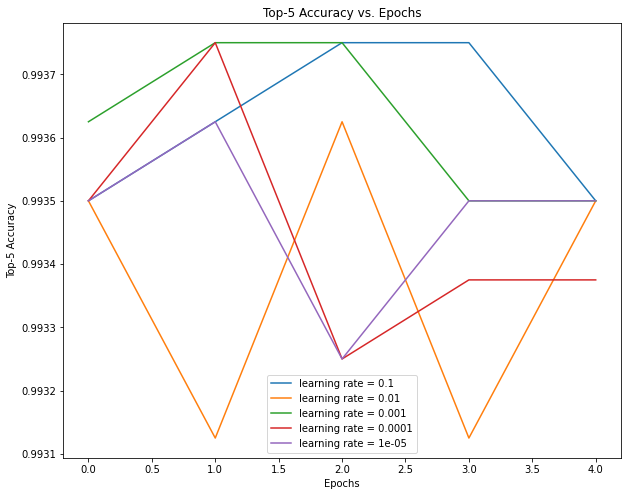

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(learning_rates)):
    ax.plot(top5_acc_lr_adagrad[i], label=f'learning rate = {learning_rates[i]}')

ax.set_title('Top-5 Accuracy vs. Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Top-5 Accuracy')
ax.legend()
plt.show()

## Trying diff Hyperparameters for RMSprop

### varying learning rate

In [ ]:
# Define optimizer and learning rate scheduler
n_epochs = 5
learning_rates = [0.1,0.01,0.001,0.0001,0.00001]

top5_acc_lr_rms = []

for LR in learning_rates:
    optimizer = optim.RMSprop(resnet_rms.parameters(), lr=LR)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Train and evaluate model
    train_losses_rms = []
    test_losses_rms = []
    train_accuracies_top1_rms = []
    test_accuracies_top1_rms = []
    train_accuracies_top5_rms = []
    test_accuracies_top5_rms = []
    for epoch in range(n_epochs):
        train_loss, train_acc_top1, train_acc_top5 = train(model, device, train_loader, optimizer, epoch, 0.001)
        test_loss, test_acc_top1, test_acc_top5 = test(model, device, test_loader, 0.001)
        train_losses_rms.append(train_loss)
        train_accuracies_top1_rms.append(train_acc_top1)
        train_accuracies_top5_rms.append(train_acc_top5)
        test_losses_rms.append(test_loss)
        test_accuracies_top1_rms.append(test_acc_top1)
        test_accuracies_top5_rms.append(test_acc_top5)
        print()
        print("Epoch: ", epoch + 1, "Train Loss: ", train_loss, "Train Acc top 1: ", train_acc_top1.item(), "Test Loss: ", test_loss, "Test Acc top 1: ", test_acc_top1)
        print("Train Acc top 5: ", train_acc_top5.item(), "Test Acc top 5: ", test_acc_top5)
        print()

    top5_acc_lr_rms.append(test_accuracies_top5_rms)


Testing: 100%|██████████| 32/32 [00:06<00:00,  5.10batch/s, loss=806]



Epoch:  1 Train Loss:  5.408947166633606 Train Acc top 1:  0.1394 Test Loss:  3.2258220901489256 Test Acc top 1:  0.1
Train Acc top 5:  0.521 Test Acc top 5:  0.5



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.07batch/s, loss=656]



Epoch:  2 Train Loss:  0.574138572692871 Train Acc top 1:  0.0994 Test Loss:  2.622857355117798 Test Acc top 1:  0.1
Train Acc top 5:  0.5006 Test Acc top 5:  0.5



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.01batch/s, loss=614]



Epoch:  3 Train Loss:  0.2302129737854004 Train Acc top 1:  0.1106 Test Loss:  2.455427042007446 Test Acc top 1:  0.1
Train Acc top 5:  0.5206000000000001 Test Acc top 5:  0.5



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.03batch/s, loss=626]



Epoch:  4 Train Loss:  0.1227424030303955 Train Acc top 1:  0.1004 Test Loss:  2.5037573509216307 Test Acc top 1:  0.1
Train Acc top 5:  0.5044000000000001 Test Acc top 5:  0.48275



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.92batch/s, loss=590]



Epoch:  5 Train Loss:  0.08558561477661132 Train Acc top 1:  0.1038 Test Loss:  2.3609603652954103 Test Acc top 1:  0.1
Train Acc top 5:  0.502 Test Acc top 5:  0.5



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.92batch/s, loss=581]



Epoch:  1 Train Loss:  0.040795902824401854 Train Acc top 1:  0.12940000000000002 Test Loss:  2.322128984451294 Test Acc top 1:  0.1
Train Acc top 5:  0.5558000000000001 Test Acc top 5:  0.5



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.89batch/s, loss=547]



Epoch:  2 Train Loss:  0.012910782194137573 Train Acc top 1:  0.18080000000000002 Test Loss:  2.1895521507263185 Test Acc top 1:  0.156
Train Acc top 5:  0.6920000000000001 Test Acc top 5:  0.642125



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.71batch/s, loss=592]



Epoch:  3 Train Loss:  0.010554757118225098 Train Acc top 1:  0.21760000000000002 Test Loss:  2.3687990798950196 Test Acc top 1:  0.1005
Train Acc top 5:  0.7556 Test Acc top 5:  0.503875



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.74batch/s, loss=491]



Epoch:  4 Train Loss:  0.009729343938827515 Train Acc top 1:  0.24200000000000002 Test Loss:  1.9651053047180176 Test Acc top 1:  0.249
Train Acc top 5:  0.785 Test Acc top 5:  0.78325



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.65batch/s, loss=611]



Epoch:  5 Train Loss:  0.008683230972290039 Train Acc top 1:  0.28600000000000003 Test Loss:  2.442847484588623 Test Acc top 1:  0.120125
Train Acc top 5:  0.8390000000000001 Test Acc top 5:  0.539



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.75batch/s, loss=470]



Epoch:  1 Train Loss:  0.008079957509040833 Train Acc top 1:  0.3164 Test Loss:  1.8784677810668946 Test Acc top 1:  0.2705
Train Acc top 5:  0.8726 Test Acc top 5:  0.807625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.70batch/s, loss=428]



Epoch:  2 Train Loss:  0.007389701604843139 Train Acc top 1:  0.3582 Test Loss:  1.712599181175232 Test Acc top 1:  0.34075
Train Acc top 5:  0.8972 Test Acc top 5:  0.856375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.64batch/s, loss=409]



Epoch:  3 Train Loss:  0.00710268292427063 Train Acc top 1:  0.39180000000000004 Test Loss:  1.6349549160003662 Test Acc top 1:  0.369
Train Acc top 5:  0.921 Test Acc top 5:  0.896875



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.69batch/s, loss=410]



Epoch:  4 Train Loss:  0.0068623236179351805 Train Acc top 1:  0.41440000000000005 Test Loss:  1.640950553894043 Test Acc top 1:  0.354625
Train Acc top 5:  0.9314 Test Acc top 5:  0.882



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.65batch/s, loss=372]



Epoch:  5 Train Loss:  0.0066249114513397215 Train Acc top 1:  0.44780000000000003 Test Loss:  1.4873412370681762 Test Acc top 1:  0.421125
Train Acc top 5:  0.9378000000000001 Test Acc top 5:  0.927375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.67batch/s, loss=351]



Epoch:  1 Train Loss:  0.006266892766952515 Train Acc top 1:  0.4822 Test Loss:  1.4057978181838988 Test Acc top 1:  0.469375
Train Acc top 5:  0.9488000000000001 Test Acc top 5:  0.939625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.64batch/s, loss=348]



Epoch:  2 Train Loss:  0.006121463394165039 Train Acc top 1:  0.5078 Test Loss:  1.392726393699646 Test Acc top 1:  0.46975
Train Acc top 5:  0.9552 Test Acc top 5:  0.941125



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.06batch/s, loss=341]



Epoch:  3 Train Loss:  0.0060334775686264035 Train Acc top 1:  0.516 Test Loss:  1.36401704120636 Test Acc top 1:  0.479375
Train Acc top 5:  0.9566 Test Acc top 5:  0.945875



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.56batch/s, loss=338]



Epoch:  4 Train Loss:  0.005953716063499451 Train Acc top 1:  0.5226000000000001 Test Loss:  1.352523838043213 Test Acc top 1:  0.482625
Train Acc top 5:  0.9588000000000001 Test Acc top 5:  0.94525



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.58batch/s, loss=338]



Epoch:  5 Train Loss:  0.005859624767303467 Train Acc top 1:  0.5378000000000001 Test Loss:  1.3538428220748902 Test Acc top 1:  0.486625
Train Acc top 5:  0.9606 Test Acc top 5:  0.943875



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.55batch/s, loss=332]



Epoch:  1 Train Loss:  0.005755833792686463 Train Acc top 1:  0.546 Test Loss:  1.3293619327545165 Test Acc top 1:  0.500125
Train Acc top 5:  0.9646 Test Acc top 5:  0.947375



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.48batch/s, loss=331]



Epoch:  2 Train Loss:  0.005724137997627258 Train Acc top 1:  0.5496 Test Loss:  1.325713604927063 Test Acc top 1:  0.50175
Train Acc top 5:  0.9658 Test Acc top 5:  0.947625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.67batch/s, loss=331]



Epoch:  3 Train Loss:  0.005706362628936768 Train Acc top 1:  0.553 Test Loss:  1.323663987159729 Test Acc top 1:  0.5025
Train Acc top 5:  0.9650000000000001 Test Acc top 5:  0.947875



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.75batch/s, loss=331]



Epoch:  4 Train Loss:  0.005687348294258118 Train Acc top 1:  0.554 Test Loss:  1.323969983100891 Test Acc top 1:  0.504
Train Acc top 5:  0.9668 Test Acc top 5:  0.948375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.88batch/s, loss=330]


Epoch:  5 Train Loss:  0.005673084568977356 Train Acc top 1:  0.5588000000000001 Test Loss:  1.3194721555709839 Test Acc top 1:  0.50525
Train Acc top 5:  0.9662000000000001 Test Acc top 5:  0.948



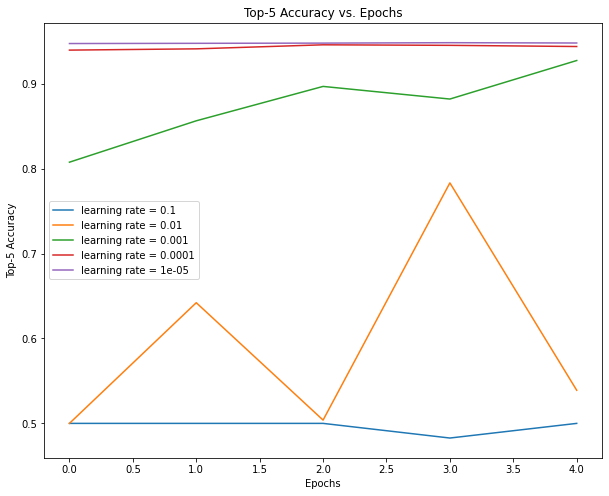

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(learning_rates)):
    ax.plot(top5_acc_lr_rms[i], label=f'learning rate = {learning_rates[i]}')

ax.set_title('Top-5 Accuracy vs. Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Top-5 Accuracy')
ax.legend()
plt.show()

### varying momentum

In [ ]:
# optimizer = optim.RMSprop(model.parameters(), lr=learning_rate, alpha=alpha, momentum=momentum, weight_decay=weight_decay)

In [ ]:
# Define optimizer and learning rate scheduler
n_epochs = 5
momentum_list = [0, 0.3, 0.5, 0.75, 0.9]

top5_acc_momen_rms = []

for ml in momentum_list:
    optimizer = optim.RMSprop(resnet_rms.parameters(), lr=3e-5, momentum = ml)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Train and evaluate model
    train_losses_rms = []
    test_losses_rms = []
    train_accuracies_top1_rms = []
    test_accuracies_top1_rms = []
    train_accuracies_top5_rms = []
    test_accuracies_top5_rms = []
    for epoch in range(n_epochs):
        train_loss, train_acc_top1, train_acc_top5 = train(model, device, train_loader, optimizer, epoch, 0.001)
        test_loss, test_acc_top1, test_acc_top5 = test(model, device, test_loader, 0.001)
        train_losses_rms.append(train_loss)
        train_accuracies_top1_rms.append(train_acc_top1)
        train_accuracies_top5_rms.append(train_acc_top5)
        test_losses_rms.append(test_loss)
        test_accuracies_top1_rms.append(test_acc_top1)
        test_accuracies_top5_rms.append(test_acc_top5)
        print()
        print("Epoch: ", epoch + 1, "Train Loss: ", train_loss, "Train Acc top 1: ", train_acc_top1.item(), "Test Loss: ", test_loss, "Test Acc top 1: ", test_acc_top1)
        print("Train Acc top 5: ", train_acc_top5.item(), "Test Acc top 5: ", test_acc_top5)
        print()

    top5_acc_momen_rms.append(test_accuracies_top5_rms)


Testing: 100%|██████████| 32/32 [00:06<00:00,  5.05batch/s, loss=329]



Epoch:  1 Train Loss:  0.005680857849121094 Train Acc top 1:  0.5568000000000001 Test Loss:  1.3141325311660768 Test Acc top 1:  0.5065
Train Acc top 5:  0.9650000000000001 Test Acc top 5:  0.948



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.17batch/s, loss=327]



Epoch:  2 Train Loss:  0.0055896211147308346 Train Acc top 1:  0.5694 Test Loss:  1.3089583826065063 Test Acc top 1:  0.509375
Train Acc top 5:  0.9680000000000001 Test Acc top 5:  0.94875



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.08batch/s, loss=324]



Epoch:  3 Train Loss:  0.005520030498504639 Train Acc top 1:  0.5770000000000001 Test Loss:  1.2972974653244018 Test Acc top 1:  0.514
Train Acc top 5:  0.9690000000000001 Test Acc top 5:  0.949375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.10batch/s, loss=322]



Epoch:  4 Train Loss:  0.005466496014595032 Train Acc top 1:  0.5802 Test Loss:  1.2881291418075562 Test Acc top 1:  0.520125
Train Acc top 5:  0.9698 Test Acc top 5:  0.9525



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.14batch/s, loss=323]



Epoch:  5 Train Loss:  0.005429480314254761 Train Acc top 1:  0.5862 Test Loss:  1.2920092706680297 Test Acc top 1:  0.519125
Train Acc top 5:  0.9698 Test Acc top 5:  0.95125



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.90batch/s, loss=321]



Epoch:  1 Train Loss:  0.005438304162025452 Train Acc top 1:  0.5832 Test Loss:  1.2849579706192016 Test Acc top 1:  0.522125
Train Acc top 5:  0.9716 Test Acc top 5:  0.95



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.57batch/s, loss=323]



Epoch:  2 Train Loss:  0.005246563053131104 Train Acc top 1:  0.6168 Test Loss:  1.2932546615600586 Test Acc top 1:  0.514875
Train Acc top 5:  0.9730000000000001 Test Acc top 5:  0.954125



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.96batch/s, loss=309]



Epoch:  3 Train Loss:  0.005117911386489868 Train Acc top 1:  0.6232 Test Loss:  1.2341965618133546 Test Acc top 1:  0.545125
Train Acc top 5:  0.9756 Test Acc top 5:  0.955375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.05batch/s, loss=316]



Epoch:  4 Train Loss:  0.0049998400211334225 Train Acc top 1:  0.6372 Test Loss:  1.2631206169128417 Test Acc top 1:  0.531375
Train Acc top 5:  0.9780000000000001 Test Acc top 5:  0.9515



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.92batch/s, loss=303]



Epoch:  5 Train Loss:  0.004904694986343384 Train Acc top 1:  0.6526000000000001 Test Loss:  1.2139261922836304 Test Acc top 1:  0.55575
Train Acc top 5:  0.9794 Test Acc top 5:  0.954125



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.88batch/s, loss=312]



Epoch:  1 Train Loss:  0.005117809534072876 Train Acc top 1:  0.6234000000000001 Test Loss:  1.247833251953125 Test Acc top 1:  0.540375
Train Acc top 5:  0.9760000000000001 Test Acc top 5:  0.95025



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.60batch/s, loss=320]



Epoch:  2 Train Loss:  0.00472189314365387 Train Acc top 1:  0.674 Test Loss:  1.2788818655014038 Test Acc top 1:  0.51825
Train Acc top 5:  0.9796 Test Acc top 5:  0.953



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.58batch/s, loss=304]



Epoch:  3 Train Loss:  0.0045346516132354735 Train Acc top 1:  0.6868000000000001 Test Loss:  1.2145077381134033 Test Acc top 1:  0.5515
Train Acc top 5:  0.9842000000000001 Test Acc top 5:  0.9555



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.54batch/s, loss=318]



Epoch:  4 Train Loss:  0.0043531656980514526 Train Acc top 1:  0.7214 Test Loss:  1.2735381431579589 Test Acc top 1:  0.529875
Train Acc top 5:  0.9850000000000001 Test Acc top 5:  0.9505



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.58batch/s, loss=299]



Epoch:  5 Train Loss:  0.004198298406600952 Train Acc top 1:  0.7314 Test Loss:  1.1951453886032104 Test Acc top 1:  0.5625
Train Acc top 5:  0.9890000000000001 Test Acc top 5:  0.9545



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.59batch/s, loss=328]



Epoch:  1 Train Loss:  0.004916544246673584 Train Acc top 1:  0.644 Test Loss:  1.3107761011123658 Test Acc top 1:  0.50825
Train Acc top 5:  0.9778 Test Acc top 5:  0.955375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.59batch/s, loss=311]



Epoch:  2 Train Loss:  0.004323798215389252 Train Acc top 1:  0.7100000000000001 Test Loss:  1.2430458974838257 Test Acc top 1:  0.5465
Train Acc top 5:  0.9854 Test Acc top 5:  0.95225



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.57batch/s, loss=335]



Epoch:  3 Train Loss:  0.0038986912727355955 Train Acc top 1:  0.7662 Test Loss:  1.3413656282424926 Test Acc top 1:  0.520625
Train Acc top 5:  0.9900000000000001 Test Acc top 5:  0.944125



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.48batch/s, loss=339]



Epoch:  4 Train Loss:  0.0035629477620124817 Train Acc top 1:  0.802 Test Loss:  1.357375761985779 Test Acc top 1:  0.521875
Train Acc top 5:  0.9918 Test Acc top 5:  0.939375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.66batch/s, loss=320]



Epoch:  5 Train Loss:  0.0033295286536216737 Train Acc top 1:  0.8226 Test Loss:  1.281483630180359 Test Acc top 1:  0.5325
Train Acc top 5:  0.9944000000000001 Test Acc top 5:  0.9575



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.58batch/s, loss=467]



Epoch:  1 Train Loss:  0.004997732961177826 Train Acc top 1:  0.6468 Test Loss:  1.8695614280700683 Test Acc top 1:  0.398875
Train Acc top 5:  0.9796 Test Acc top 5:  0.9215



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.04batch/s, loss=366]



Epoch:  2 Train Loss:  0.004523993396759033 Train Acc top 1:  0.7130000000000001 Test Loss:  1.4643143091201782 Test Acc top 1:  0.498125
Train Acc top 5:  0.9880000000000001 Test Acc top 5:  0.952125



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.10batch/s, loss=327]



Epoch:  3 Train Loss:  0.003914924967288971 Train Acc top 1:  0.771 Test Loss:  1.3087264575958253 Test Acc top 1:  0.53875
Train Acc top 5:  0.9908 Test Acc top 5:  0.9515



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.07batch/s, loss=356]



Epoch:  4 Train Loss:  0.0033390191555023193 Train Acc top 1:  0.8214 Test Loss:  1.4233701581954956 Test Acc top 1:  0.518625
Train Acc top 5:  0.9944000000000001 Test Acc top 5:  0.940375



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.11batch/s, loss=362]


Epoch:  5 Train Loss:  0.002834469509124756 Train Acc top 1:  0.8726 Test Loss:  1.4465999927520752 Test Acc top 1:  0.536125
Train Acc top 5:  0.996 Test Acc top 5:  0.946125



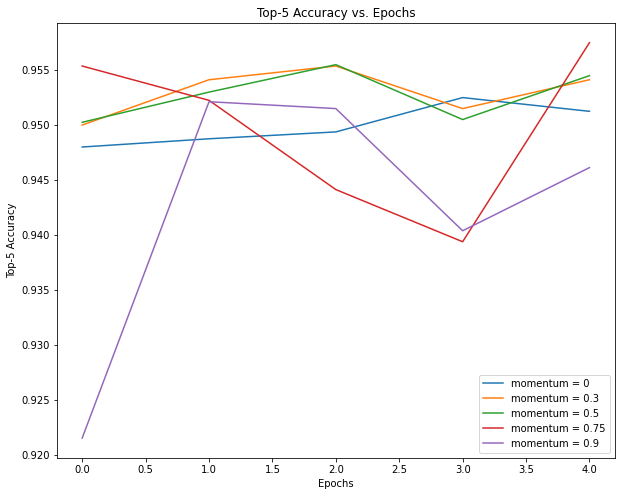

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(momentum_list)):
    ax.plot(top5_acc_momen_rms[i], label=f'momentum = {momentum_list[i]}')

ax.set_title('Top-5 Accuracy vs. Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Top-5 Accuracy')
ax.legend()
plt.show()

### varying alpha

In [ ]:
# Define optimizer and learning rate scheduler
n_epochs = 5
alpha_list = [0,0.1,0.01,0.001,0.0001]

top5_acc_alpha_rms = []

for ml in alpha_list:
    optimizer = optim.RMSprop(resnet_rms.parameters(), lr=3e-5, alpha = ml)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

    # Train and evaluate model
    train_losses_rms = []
    test_losses_rms = []
    train_accuracies_top1_rms = []
    test_accuracies_top1_rms = []
    train_accuracies_top5_rms = []
    test_accuracies_top5_rms = []
    for epoch in range(n_epochs):
        train_loss, train_acc_top1, train_acc_top5 = train(model, device, train_loader, optimizer, epoch, 0.001)
        test_loss, test_acc_top1, test_acc_top5 = test(model, device, test_loader, 0.001)
        train_losses_rms.append(train_loss)
        train_accuracies_top1_rms.append(train_acc_top1)
        train_accuracies_top5_rms.append(train_acc_top5)
        test_losses_rms.append(test_loss)
        test_accuracies_top1_rms.append(test_acc_top1)
        test_accuracies_top5_rms.append(test_acc_top5)
        print()
        print("Epoch: ", epoch + 1, "Train Loss: ", train_loss, "Train Acc top 1: ", train_acc_top1.item(), "Test Loss: ", test_loss, "Test Acc top 1: ", test_acc_top1)
        print("Train Acc top 5: ", train_acc_top5.item(), "Test Acc top 5: ", test_acc_top5)
        print()

    top5_acc_alpha_rms.append(test_accuracies_top5_rms)


Testing: 100%|██████████| 32/32 [00:06<00:00,  5.03batch/s, loss=307]



Epoch:  1 Train Loss:  0.0022066097676754 Train Acc top 1:  0.9460000000000001 Test Loss:  1.2291533098220826 Test Acc top 1:  0.587125
Train Acc top 5:  0.9974000000000001 Test Acc top 5:  0.95825



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.98batch/s, loss=308]



Epoch:  2 Train Loss:  0.00206620187163353 Train Acc top 1:  0.9566 Test Loss:  1.2320708265304565 Test Acc top 1:  0.583375
Train Acc top 5:  0.9978 Test Acc top 5:  0.957625



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.04batch/s, loss=309]



Epoch:  3 Train Loss:  0.001981516969203949 Train Acc top 1:  0.9666 Test Loss:  1.236779101371765 Test Acc top 1:  0.5885
Train Acc top 5:  0.998 Test Acc top 5:  0.957875



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.00batch/s, loss=311]



Epoch:  4 Train Loss:  0.0019353363037109374 Train Acc top 1:  0.9666 Test Loss:  1.2449021587371827 Test Acc top 1:  0.58775
Train Acc top 5:  0.9978 Test Acc top 5:  0.95825



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.01batch/s, loss=314]



Epoch:  5 Train Loss:  0.0018756568312644959 Train Acc top 1:  0.9738 Test Loss:  1.2575916233062745 Test Acc top 1:  0.586125
Train Acc top 5:  0.9982000000000001 Test Acc top 5:  0.95625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.72batch/s, loss=313]



Epoch:  1 Train Loss:  0.0018278266847133635 Train Acc top 1:  0.9782000000000001 Test Loss:  1.2516234016418457 Test Acc top 1:  0.586
Train Acc top 5:  0.9988 Test Acc top 5:  0.95675



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.59batch/s, loss=316]



Epoch:  2 Train Loss:  0.0017950368225574493 Train Acc top 1:  0.9780000000000001 Test Loss:  1.2628557147979735 Test Acc top 1:  0.585625
Train Acc top 5:  0.9988 Test Acc top 5:  0.95675



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.61batch/s, loss=318]



Epoch:  3 Train Loss:  0.0017454679012298584 Train Acc top 1:  0.9812000000000001 Test Loss:  1.2732817153930664 Test Acc top 1:  0.585625
Train Acc top 5:  0.9988 Test Acc top 5:  0.957875



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.63batch/s, loss=320]



Epoch:  4 Train Loss:  0.0016960860311985015 Train Acc top 1:  0.9856 Test Loss:  1.2802116012573241 Test Acc top 1:  0.585
Train Acc top 5:  0.9992000000000001 Test Acc top 5:  0.957625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.64batch/s, loss=322]



Epoch:  5 Train Loss:  0.001658463180065155 Train Acc top 1:  0.9872000000000001 Test Loss:  1.2884271173477173 Test Acc top 1:  0.5825
Train Acc top 5:  0.9988 Test Acc top 5:  0.95675



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.51batch/s, loss=323]



Epoch:  1 Train Loss:  0.0016277863264083862 Train Acc top 1:  0.9894000000000001 Test Loss:  1.292339238166809 Test Acc top 1:  0.58475
Train Acc top 5:  0.9988 Test Acc top 5:  0.957625



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.51batch/s, loss=332]



Epoch:  2 Train Loss:  0.0015860346078872681 Train Acc top 1:  0.9900000000000001 Test Loss:  1.3266535844802856 Test Acc top 1:  0.575375
Train Acc top 5:  0.9992000000000001 Test Acc top 5:  0.955125



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.45batch/s, loss=325]



Epoch:  3 Train Loss:  0.0015569057047367097 Train Acc top 1:  0.993 Test Loss:  1.2990436611175538 Test Acc top 1:  0.584875
Train Acc top 5:  0.9992000000000001 Test Acc top 5:  0.956875



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.50batch/s, loss=328]



Epoch:  4 Train Loss:  0.0015245174884796142 Train Acc top 1:  0.9932000000000001 Test Loss:  1.3123854885101318 Test Acc top 1:  0.583125
Train Acc top 5:  0.9992000000000001 Test Acc top 5:  0.958125



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.67batch/s, loss=329]



Epoch:  5 Train Loss:  0.001498162364959717 Train Acc top 1:  0.994 Test Loss:  1.314585747718811 Test Acc top 1:  0.584125
Train Acc top 5:  0.999 Test Acc top 5:  0.957375



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.85batch/s, loss=331]



Epoch:  1 Train Loss:  0.0014609824001789093 Train Acc top 1:  0.9964000000000001 Test Loss:  1.3229217538833618 Test Acc top 1:  0.58375
Train Acc top 5:  0.999 Test Acc top 5:  0.954625



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.94batch/s, loss=338]



Epoch:  2 Train Loss:  0.001443948769569397 Train Acc top 1:  0.9964000000000001 Test Loss:  1.350044137954712 Test Acc top 1:  0.57725
Train Acc top 5:  0.9992000000000001 Test Acc top 5:  0.957



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.02batch/s, loss=333]



Epoch:  3 Train Loss:  0.0014060955405235291 Train Acc top 1:  0.9974000000000001 Test Loss:  1.3323026695251465 Test Acc top 1:  0.58325
Train Acc top 5:  0.9992000000000001 Test Acc top 5:  0.955875



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.04batch/s, loss=335]



Epoch:  4 Train Loss:  0.0013961987733840941 Train Acc top 1:  0.9966 Test Loss:  1.3391300430297852 Test Acc top 1:  0.582875
Train Acc top 5:  0.999 Test Acc top 5:  0.95475



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.88batch/s, loss=339]



Epoch:  5 Train Loss:  0.0013606018960475922 Train Acc top 1:  0.998 Test Loss:  1.354884614944458 Test Acc top 1:  0.5795
Train Acc top 5:  0.9998 Test Acc top 5:  0.95575



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.94batch/s, loss=342]



Epoch:  1 Train Loss:  0.0013503041744232177 Train Acc top 1:  0.9978 Test Loss:  1.3672934312820435 Test Acc top 1:  0.579375
Train Acc top 5:  0.9994000000000001 Test Acc top 5:  0.955625



Testing: 100%|██████████| 32/32 [00:06<00:00,  5.06batch/s, loss=349]



Epoch:  2 Train Loss:  0.0013267924606800078 Train Acc top 1:  0.9984000000000001 Test Loss:  1.396013918876648 Test Acc top 1:  0.579375
Train Acc top 5:  0.9998 Test Acc top 5:  0.95575



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.97batch/s, loss=341]



Epoch:  3 Train Loss:  0.0013074168741703032 Train Acc top 1:  0.9986 Test Loss:  1.3647297105789185 Test Acc top 1:  0.58325
Train Acc top 5:  0.9998 Test Acc top 5:  0.956



Testing: 100%|██████████| 32/32 [00:06<00:00,  4.90batch/s, loss=346]



Epoch:  4 Train Loss:  0.0012806937575340271 Train Acc top 1:  0.999 Test Loss:  1.3842113456726075 Test Acc top 1:  0.575375
Train Acc top 5:  0.9998 Test Acc top 5:  0.955125



Testing: 100%|██████████| 32/32 [00:07<00:00,  4.15batch/s, loss=356]


Epoch:  5 Train Loss:  0.0012773824453353882 Train Acc top 1:  0.999 Test Loss:  1.4229424724578856 Test Acc top 1:  0.573375
Train Acc top 5:  1.0 Test Acc top 5:  0.95225



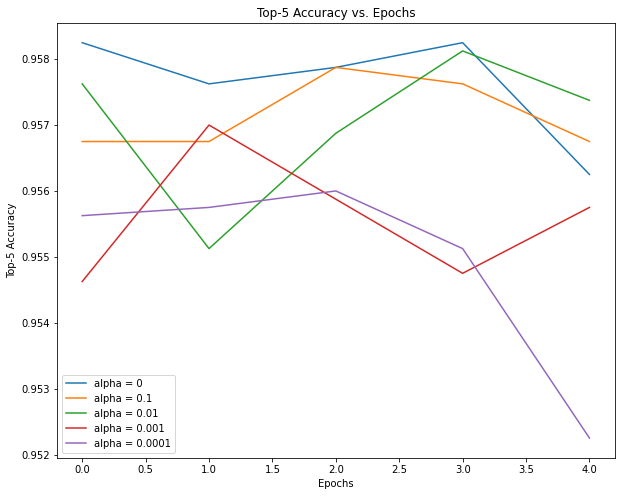

In [ ]:
# Plot the results
fig, ax = plt.subplots(figsize=(10, 8))

for i in range(len(alpha_list)):
    ax.plot(top5_acc_alpha_rms[i], label=f'alpha = {alpha_list[i]}')

ax.set_title('Top-5 Accuracy vs. Epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Top-5 Accuracy')
ax.legend()
plt.show()